<a href="https://colab.research.google.com/github/sbmoyano/data_science_projects/blob/master/fraud_detection/xgboost_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I will train **XGBoost** and **LightGBM** models with the train and validation sets created in the previous notebooks.

* I will evaluate its performance and measure bias and variance in these models, and apply regularization techniques when necessary to improve model generalization.

* I will also tune hyperparameters in different steps, focusing first in the tree-specific hyperparameters. Second, I will tune some hyperparameters known to make the model more consevative. Third I will include regularization hyperparameters if necessary and finally the learning rate.

* I will try to **minimize the loss** as it offers more variability through boosting rounds compared to AUC.

**METRICS**

During training and evaluating the models, I will focus on **reducing the loss and increasing the area under the curve (AUC)**, as it is not affected by imbalanced datasets. **Postive weight** I will also computed for the model to consider class imbalance during training.

Although these are going to be our main metrics to visualize model performance, I will also extract a confusion matrix and compute **True Positive Rate** and **False Positive Rate**. I would like to increase the number of True Positives and reduce the number of False Positives as much as possible. Specifically, the latter is known to have a negative impact on business, as I will be labelling legit transactions as fraud, leading to a negative experience of costumber with the service.

**HYPERPARAMETER TUNING**

I will **focus on reducing the loss** as AUC is already high even in the first epochs, offering less variability. I will use Optuna for hyperparameter tuning, returning the mean of the loss for each hyperparameter combination. I will keep the combination that gives us the lowest loss.

*Note. Due to GPU limitations in Google Colab, I can not train the model for too long or perform a hyperparameter search on a bigger space*



In [ ]:
! pip install optuna
! pip install cmake
! pip install shap
! pip install -U xgboost # Update XGBoost version installed in Colab (Installed in Colab is 0.90)
! git clone --recursive https://github.com/Microsoft/LightGBM # clone the latest version of LightGBM (installed in Colab is 2.2.1)
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu; # LightGBM allow GPU usage
import os
os.kill(os.getpid(), 9) # restart runtime to use the latest XGBoost and LightGBM version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'LightGBM' already exists and is not an empty directory.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -

# Set environment

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import os
from collections import Counter

# Visualization
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
import matplotlib.pyplot as plt
import shap

# feature engineering
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, f1_score

# XGBoost
import xgboost as xgb

# tensorflow
import tensorflow as tf

# LightGBM
import lightgbm
from lightgbm import LGBMClassifier

# hyperparameter tuning
import optuna
from optuna.samplers import RandomSampler

In [ ]:
# check if I am connected to GPU
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import data

In [ ]:
# connect to GoogleDrive on Colab to import data
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path for Colab
data_path_gd = "drive/MyDrive/GITHUB/data_science_projects/fraud_detection/.data/.processed/"
model_path_gd = "drive/MyDrive/GITHUB/data_science_projects/fraud_detection/.models"

In [ ]:
# import on Colab
X_train = np.load(os.path.join(data_path_gd, "X_train_np.npy"))
X_test = np.load(os.path.join(data_path_gd, "X_test_np.npy"))
X_val = np.load(os.path.join(data_path_gd, "X_val_np.npy"))
y_train = np.load(os.path.join(data_path_gd, "y_train_np.npy"))
y_test = np.load(os.path.join(data_path_gd, "y_test_np.npy"))
y_val = np.load(os.path.join(data_path_gd, "y_val_np.npy"))

In [ ]:
X_train

array([[-1.64338887, -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5312581 , -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5312581 , -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.63421191, -1.71653013, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52208113, -1.71653013,  1.32038104, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52208113, -1.71653013,  1.32038104, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# import on Colab
X_train_df = pd.read_csv(os.path.join(data_path_gd, "X_train_df.csv"), index_col=0)
X_test_df = pd.read_csv(os.path.join(data_path_gd, "X_test_df.csv"), index_col=0)
X_val_df = pd.read_csv(os.path.join(data_path_gd, "X_val_df.csv"), index_col=0)
y_train_df = pd.read_csv(os.path.join(data_path_gd, "y_train_df.csv"), index_col=0)
y_test_df = pd.read_csv(os.path.join(data_path_gd, "y_test_df.csv"), index_col=0)
y_val_df = pd.read_csv(os.path.join(data_path_gd, "y_val_df.csv"), index_col=0)

In [ ]:
display(X_train_df.head())
print(X_train_df.columns)

day      week  is_weekend   amt_log  merch_lat  merch_long  \
0 -1.643389 -1.781587   -0.757357 -1.060622   1.064712   -1.416337   
1 -1.531258 -1.781587   -0.757357  0.369892   0.681984   -1.365695   
2 -1.531258 -1.781587   -0.757357  0.685878   0.866421   -1.373925   
3 -1.531258 -1.781587   -0.757357  0.067388   0.722970   -1.344176   
4 -1.531258 -1.781587   -0.757357 -0.110475   0.936944   -1.296524   

   total_seconds_day      hour       age       zip  ...  category_grocery_pos  \
0          -0.076532 -0.118803 -0.737671  1.253131  ...                     0   
1          -0.668388 -0.705570 -0.737671  1.253131  ...                     0   
2          -0.661915 -0.705570 -0.737671  1.253131  ...                     0   
3          -0.098557 -0.118803 -0.737671  1.253131  ...                     0   
4          -0.019089  0.027889 -0.737671  1.253131  ...                     0   

   category_health_fitness  category_home  category_kids_pets  \
0                        0              0                   0   
1                        0              0                   0   
2                        0              0                   0   
3                        0              0                   1   
4                        0              1                   0   

   category_misc_net  category_misc_pos  category_personal_care  \
0                  1                  0                       0   
1                  0                  0                       0   
2                  0                  0                       0   
3                  0                  0                       0   
4                  0                  0                       0   

   category_shopping_net  category_shopping_pos  category_travel  
0                      0                      0                0  
1                      0                      0                0  
2                      0                      0                0  
3                      0                      0                0  
4                      0                      0                0  

[5 rows x 39 columns]

Index(['day', 'week', 'is_weekend', 'amt_log', 'merch_lat', 'merch_long',
       'total_seconds_day', 'hour', 'age', 'zip', 'month', 'city_pop',
       'amt_week_quarter', 'amt_day_7d_merch', 'amt_day_30d_merch',
       'amt_day_30d_cat', 'amt_day_7d_cat', 'amt_day_month_merch_quarter',
       'amt_day_week_merch_quarter', 'cumsum_amt_day', 'cumcount_trans_day',
       'cumcount_trans_month_merch', 'time_since_last_trans', 'lag_fraud',
       'distance', 'gender_m', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel'],
      dtype='object')


In [ ]:
y_train_df.head()

is_fraud
1017         0
2724         0
2726         0
2882         0
2907         0

In [ ]:
# # import on Jupyter Notebook
# X_train = np.load(os.path.join(os.getcwd(), ".data/.processed/X_train_np.npy"))
# X_test = np.load(os.path.join(os.getcwd(), ".data/.processed/X_test_np.npy"))
# X_val = np.load(os.path.join(os.getcwd(), ".data/.processed/X_val_np.npy"))
# y_train = np.load(os.path.join(os.getcwd(), ".data/.processed/y_train_np.npy"))
# y_test = np.load(os.path.join(os.getcwd(), ".data/.processed/y_test_np.npy"))
# y_val = np.load(os.path.join(os.getcwd(), ".data/.processed/y_val_np.npy"))

In [ ]:
# directory to store models
models_dir = os.path.join(os.getcwd(), '.models')

# create directories if they do not exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [ ]:
seed_number = 42

# Custom functions

In [ ]:
def plot_model_performance(i, auc_train, auc_val, loss_train, loss_val):
  
  """
  Plot AUC scores for training and validation sets thorughout model's iterations
  and loss scores of both sets in two independent plots.

  Input:
    i (list): iteration number.
    auc_train (list): auc scores for each iteration in i.
    auc_val (list): auc scores for each iteration in i.
    loss_train (list): loss scores for each iteration in i.
    loss_val (list): loss scores for each iteration in i.
  
  Output:
    None. The function displays the plots.
  """

  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  ax[0].plot(i, auc_train, label="AUC training")
  ax[0].plot(i, auc_val, label="AUC validation")
  ax[1].plot(i, loss_train, label="Logloss training")
  ax[1].plot(i, loss_val, label="Logloss validation")
  ax[0].legend(frameon=False)
  ax[1].legend(frameon=False)
  sns.despine()

In [ ]:
def get_xgboost_evals_results(evals_results):

  """
  Get evaluations results for loss and AUC in independent lists.

  Input:
    evals_results (dict): dictionary with evaluation results from an XGBoost
                          model. It could be obtain with the method 
                          model.evals_results()
  
  Output:
    auc_scores_train (list): list with the training set AUCs scores through all
                             the model iterations.
    auc_scores_val (list): list with the valitions set AUCs scores through all
                           the model iterations.
    logloss_scores_train (list): list with the training set loss scores through all
                                 the model iterations.
    logloss_scores_val (list): list with the valitions set loss scores through all
                               the model iterations.
    i_list (list): list with iteration number.
  """

  i_list = []
  auc_scores_train = []
  auc_scores_val = []
  loss_scores_train = []
  loss_scores_val = []

  for i, auc_score in enumerate(evals_results["validation_0"]["auc"]):
      i_list.append(i)
      auc_scores_train.append(auc_score)

  for i, auc_score in enumerate(evals_results["validation_1"]["auc"]):
      auc_scores_val.append(auc_score)
      
  for i, logloss_score in enumerate(evals_results["validation_0"]["logloss"]):
      loss_scores_train.append(logloss_score)

  for i, logloss_score in enumerate(evals_results["validation_1"]["logloss"]):
      loss_scores_val.append(logloss_score)
  
  return auc_scores_train, auc_scores_val, loss_scores_train, loss_scores_val, i_list

In [ ]:
def get_lgbm_evals_results(evals_results):

  """
  Get evaluations results for loss and AUC in independent lists.

  Input:
    evals_results (dict): dictionary with evaluation results from an XGBoost
                          model. It could be obtain with the method 
                          model.evals_results()
  
  Output:
    auc_scores_train (list): list with the training set AUCs scores through all
                             the model iterations.
    auc_scores_val (list): list with the valitions set AUCs scores through all
                           the model iterations.
    logloss_scores_train (list): list with the training set loss scores through all
                                 the model iterations.
    logloss_scores_val (list): list with the valitions set loss scores through all
                               the model iterations.
    i_list (list): list with iteration number.
  """

  i_list = []
  auc_scores_train = []
  auc_scores_val = []
  loss_scores_train = []
  loss_scores_val = []

  for i, auc_score in enumerate(evals_results["training"]["auc"]):
      i_list.append(i)
      auc_scores_train.append(auc_score)

  for i, auc_score in enumerate(evals_results["valid_1"]["auc"]):
      auc_scores_val.append(auc_score)
      
  for i, logloss_score in enumerate(evals_results["training"]["binary_logloss"]):
      loss_scores_train.append(logloss_score)

  for i, logloss_score in enumerate(evals_results["valid_1"]["binary_logloss"]):
      loss_scores_val.append(logloss_score)
  
  return auc_scores_train, auc_scores_val, loss_scores_train, loss_scores_val, i_list

In [ ]:
def tune_optuna(model, device, study_name):

    """
    Function to tune hyperparameters using Optuna, creating and optimizing
    the study object.

    Input:
      model (str): either 'xgboost' to use the XGBoost objective function or
                   'lgbm' to used the LightGBM objetive function.
      device (str): either 'cpu' or 'gpu'
      study_name (str): name of the study created to be optimized.
    
    Output:
      best_params (dict): best hyperparameters found by Optuna
      best_score (dict): best score found by Optuna on the selected metric

    """

    best_params = {}
    best_score = {}
    
    if model == "xgboost":

      func = lambda trial: objective_xgb(trial,
                                         X_train, 
                                         y_train, 
                                         X_val, 
                                         y_val,
                                         device)
    elif model == "lgbm":

      func = lambda trial: objective_lgbm(trial,
                                          X_train, 
                                          y_train, 
                                          X_val, 
                                          y_val,
                                          device)

    # instantiate Optuna"s Random Sampler
    study = optuna.create_study(sampler=RandomSampler(seed=seed_number),
                                direction="minimize", # maximize the target metric
                                study_name=study_name)
    
    study.optimize(func, n_trials=20)
    
    # get best parameters and best value
    best_params[bin] = study.best_params
    best_score[bin] = study.best_value
    
    return best_params, best_score

In [ ]:
def get_metrics(y_true, y_pred, set_name="test"):

  """
  Get False Positive Rate (FPR), True Positive Rate (TPR), False Negative Rate
  (FNR) and True Negative Rate (TNR) based on classification results provided
  by a confusion matrix.

  Input:
    y_true:
    y_pred:

  Output:
    None. It prints the scores.
  """

  # get confusion matrix
  conf_mtx = confusion_matrix(y_true, y_pred)

  # confusion matrix to pandas DataFrame
  conf_mtx = pd.DataFrame(conf_mtx, 
                          columns=["non-fraud (prediction)", 
                                    "fraud (prediction)"], 
                          index=["non-fraud (ground truth)", 
                                  "fraud (ground truth)"])

  # get FPs, FNs, TPs and TNs
  FP = conf_mtx.loc["non-fraud (ground truth)", "fraud (prediction)"]
  FN = conf_mtx.loc["fraud (ground truth)", "non-fraud (prediction)"]
  TP = conf_mtx.loc["fraud (ground truth)", "fraud (prediction)"]
  TN = conf_mtx.loc["non-fraud (ground truth)", "non-fraud (prediction)"]

  # round decimals
  FPR = round((FP/(FP+TN))*100, 5)
  TPR = round((TP/(TP+FN))*100, 5)
  FNR = round((FN/(FN+TP))*100, 5)
  TNR = round((TN/(TN+FP))*100, 5)

  # print results
  display(conf_mtx)

  print("AUC on {} set: {}".format(set_name, round(roc_auc_score(y_true, 
                                                                 y_pred), 5)))
  print("FPR on {} set: {}".format(set_name, FPR))
  print("TPR on {} set: {}".format(set_name, TPR))
  print("FNR on {} set: {}".format(set_name, FNR))
  print("TNR on {} set: {}".format(set_name, TNR))

In [ ]:
def get_scores_thresholds(y, X, model, thresholds):

  """
  Returns a pandas DataFrame with scores for different thresholds of the trained 
  model.

  Input: 


  Output:
    df_thresholds (DataFrame): pandas DataFrame with scores for each threshold
                               used. Each row contains a different threshold and
                               each column a different score.
  """
  
  # conf_matrices = {}
  
  # create empty DataFrame
  df_thresholds = pd.DataFrame()

  for threshold in thresholds:
      
      print("Working on result for threshold: {}".format(threshold))

      # create empty dictionary to store values at each iteration
      scores_thresholds_out = {}

      # get model predictions on the test set for each threshold
      predictions = np.ndarray.flatten((model.predict_proba(
          X)[:, 1] > threshold)).astype("int32")
      
      # get confusion matrix
      conf_mtx = confusion_matrix(y, predictions)

      # confusion matrix to pandas DataFrame
      conf_mtx = pd.DataFrame(conf_mtx, 
                              columns=["non-fraud (prediction)", 
                                        "fraud (prediction)"], 
                              index=["non-fraud (ground truth)", 
                                      "fraud (ground truth)"])

      # get FPs, FNs, TPs and TNs
      FP = conf_mtx.loc["non-fraud (ground truth)", "fraud (prediction)"]
      FN = conf_mtx.loc["fraud (ground truth)", "non-fraud (prediction)"]
      TP = conf_mtx.loc["fraud (ground truth)", "fraud (prediction)"]
      TN = conf_mtx.loc["non-fraud (ground truth)", "non-fraud (prediction)"]

      # round decimals
      FPR = round((FP/(FP+TN))*100, 5)
      TPR = round((TP/(TP+FN))*100, 5)
      FNR = round((FN/(FN+TP))*100, 5)
      TNR = round((TN/(TN+FP))*100, 5)

      # extract basic metrics from the dictionary for each threshold
      scores_thresholds_out["Threshold"] = threshold
      scores_thresholds_out["TP"] = TP
      scores_thresholds_out["FP"] = FP
      scores_thresholds_out["TN"] = TN
      scores_thresholds_out["FN"] = FN
      scores_thresholds_out["TPR"] = TPR
      scores_thresholds_out["FPR"] = FPR
      scores_thresholds_out["TNR"] = TNR
      scores_thresholds_out["FNR"] = FNR
            
      # BER score
      scores_thresholds_out["BER"] = 0.5*((scores_thresholds_out["FN"]/(
        scores_thresholds_out["TP"]+scores_thresholds_out["FN"]))+scores_thresholds_out["FP"]/(
                                                          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))
      
      # G-mean score
      scores_thresholds_out["G-mean"] = np.sqrt(scores_thresholds_out["TPR"]*scores_thresholds_out["TN"]/(
          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))
      
      # as I only get one AUC score with evaluate, I will have to predict for
      # each threshold and compute the AUC score
      scores_thresholds_out["F1_micro"] = round(f1_score(y, 
                                                         predictions, 
                                                         average="micro"), 5)
      scores_thresholds_out["AUC"] = round(roc_auc_score(y, 
                                                         predictions), 5)
      
      # append results for each threshold to a DataFrame
      df_thresholds = df_thresholds.append(scores_thresholds_out, ignore_index=True)
  
  df_thresholds.set_index("Threshold", inplace=True)

  return df_thresholds

# Positive weight

As XGBoost does not include a hyperparameter for class weights, I will use this one in both models in order to increase the weight of the fraud transactions/positive class, as it is underepresented in the train set (minority class) compared to non-fraud transactions (majority class). 

In [ ]:
# count the number of fraud and non-fraud transactions
count = Counter(y_train)

# compute positive weight
scale_pos_weight = count[0] / count[1]

# print
print(scale_pos_weight)

175.48886393411942


#Modeling

## XGBoost Classifier - Simple model

For the XGBoost Classifier, I will set the loss to 'binary:logistic', which sets the 'logloss' as a defaul evaluation metric. Apart from 'logloss' I will also add 'auc'. I will set subsample and colsample_bytree to 0.8 to use bagging, and I will use the default learning rate of 0.3

I will not touch 'missing' parameters as I do not have any missing value in the dataset.

Once the model stops training, I will plot the loss and auc scores thorugh all the training epochs to visualize identify model bias and variance.

Finally, I will evaluate its generalization to the test set computing AUC, extracting a confusion matrix and ratio scores: FPR, FNR, TPR, TNR.

In [ ]:
clf_xgb_base = xgb.XGBClassifier(objective="binary:logistic",
                                 n_estimators=100, # try this value for an intial model
                                 subsample=0.8, # use this by default to use bagging
                                 colsample_bytree=0.8, # use this by default to use bagging
                                 scale_pos_weight=scale_pos_weight,
                                 use_label_encoder=False,
                                 tree_method="gpu_hist", # set to 'gpu_hist' to use GPU
                                 random_state=seed_number,
                                 eval_metric=["auc", "logloss"])

clf_xgb_base.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_val, y_val)],
                 verbose=True)

[0]	validation_0-auc:0.99270	validation_0-logloss:0.45364	validation_1-auc:0.99007	validation_1-logloss:0.45394
[1]	validation_0-auc:0.99943	validation_0-logloss:0.31088	validation_1-auc:0.99955	validation_1-logloss:0.31186
[2]	validation_0-auc:0.99964	validation_0-logloss:0.22644	validation_1-auc:0.99961	validation_1-logloss:0.22760
[3]	validation_0-auc:0.99983	validation_0-logloss:0.16388	validation_1-auc:0.99983	validation_1-logloss:0.16524
[4]	validation_0-auc:0.99982	validation_0-logloss:0.12462	validation_1-auc:0.99979	validation_1-logloss:0.12539
[5]	validation_0-auc:0.99981	validation_0-logloss:0.09663	validation_1-auc:0.99976	validation_1-logloss:0.09748
[6]	validation_0-auc:0.99987	validation_0-logloss:0.07232	validation_1-auc:0.99985	validation_1-logloss:0.07329
[7]	validation_0-auc:0.99990	validation_0-logloss:0.05553	validation_1-auc:0.99989	validation_1-logloss:0.05666
[8]	validation_0-auc:0.99991	validation_0-logloss:0.04283	validation_1-auc:0.99990	validation_1-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['auc', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

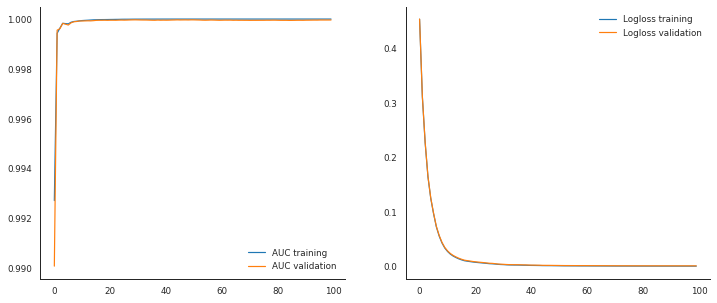

In [ ]:
# extract evaluation results
evals_results_xgb_base = clf_xgb_base.evals_result()

# extract loss and AUC by epoch
auc_scores_train_base, auc_scores_val_base, loss_scores_train_base, loss_scores_val_base, i_list_base = get_xgboost_evals_results(evals_results_xgb_base)

# plot loss and AUC
plot_model_performance(i_list_base, auc_scores_train_base, auc_scores_val_base, 
                       loss_scores_train_base, loss_scores_val_base)

In [ ]:
# XGBClassifier predictions
preds_xgb_base = clf_xgb_base.predict(X_test)
preds_xgb_base_train = clf_xgb_base.predict(X_train)
preds_xgb_base_val = clf_xgb_base.predict(X_val)

In [ ]:
get_metrics(y_test, preds_xgb_base)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  553520                  54
fraud (ground truth)                          52                2093

AUC on test set: 0.98783
FPR on test set: 0.00975
TPR on test set: 97.57576
FNR on test set: 2.42424
TNR on test set: 99.99025


In [ ]:
get_metrics(y_train, preds_xgb_base_train)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  937634                   3
fraud (ground truth)                           0                5343

AUC on test set: 1.0
FPR on test set: 0.00032
TPR on test set: 100.0
FNR on test set: 0.0
TNR on test set: 99.99968


In [ ]:
get_metrics(y_val, preds_xgb_base_val)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  349047                  41
fraud (ground truth)                          18                2121

AUC on test set: 0.99573
FPR on test set: 0.01174
TPR on test set: 99.15849
FNR on test set: 0.84151
TNR on test set: 99.98826


## Hyperparameter tuning

During hyperparameter tuning I will focus on minimizing logloss as it offers more variability than AUC, with the latter being higher from the first epochs.

Specifically, I will optimize the following hyperparameters:

* n_estimators: number of estimators in the model.
* max_depth: maximum depth of the trees.
* subsample: randomly sampled observations considered by a tree.
* colsample_bytree: randomly selected features to be considered by a tree.
* min_child_weight: helps to make the algorithm more conservative controlling overfitting. It makes sure to make valid splits, that is justified, based on the probabilities for each class, if they are matures enough or not.
* gamma: reduction in loss for the model to make a split. It could help to reduce overfitting keeping shallow trees.
* reg_lambda: L2 regularization
* learning rate

I will tune first the hyperparameters related to tree-specific functions, then regularization hyperparameters and finally the learning rate. With this approach, the randomized search could create more combinations of hyperparameters that are specific to some functionionality of the model.

1. Tune tree-specific hyperparameters
2. Tune regularization hyperparameters
3. Tune learning rate

*Note. I am tuning L2 regularization, although maybe this is not neccesary considering that I am also tuning subsample, colsample_bytree, gamma or max_depth, which could help to handle the small overfitting that I have seen in the AUC curve.*

*Note. I decided not to tune 'min_child_weight' and 'gamma', as the default values after tunning the rest of parameters gave a much better results for the FPR that tuning them:* 

* *Tuning 'min_child_weight' and 'gamma': AUC of .99, TPR of 98.04 and FPR of .01*
*  *Without tuning 'min_child_weight' and 'gamma': AUC of .99, TPR of 97.62 and FPR of .005*

*This is why you won't see a section in which I tune these parameters*

### Booster parameters

In [ ]:
def objective_xgb(trial, X_train, y_train, X_val, y_val, device):

    """
    Objective function to be used for hyperparameter tuning
    for XGBoost with Optuna.

    Input:
        trial (int): number of predefined trials during hyperparameter
                     tuning.
        X_train
        y_train
        X_val
        y_val
    Output:
        scores: f1 scores.
    """
      
    if device == "cpu":
      tree_method = "auto"
    elif device == "gpu":
      tree_method="gpu_hist"

    xgb_param_grid = {"n_estimators": trial.suggest_int("n_estimators", 10, 500, step=10),
                      "max_depth": trial.suggest_int("max_depth", 3, 12),
                      "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
                      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9, step=0.1)}

    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_1-logloss") # validation_1 corresponds to X_val and y_val, while validation_0 correspond to train dataset   

    model = xgb.XGBClassifier(objective="binary:logistic",
                              scale_pos_weight=scale_pos_weight,
                              use_label_encoder=False,
                              tree_method=tree_method,
                              random_state=seed_number,
                              eval_metric=["auc", "logloss"],
                              **xgb_param_grid)

    model.fit(X_train,
              y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)])
    
    return np.mean(model.evals_result()["validation_1"]["logloss"])

In [ ]:
xgb_hp_tree_params, xgb_hp_tree_score = tune_optuna(model="xgboost", device="gpu", study_name="XGBoost_tree_params")

[I 2022-11-12 15:31:28,877] A new study created in memory with name: XGBoost_tree_params


[0]	validation_0-auc:0.99638	validation_0-logloss:0.44172	validation_1-auc:0.99170	validation_1-logloss:0.44237
[1]	validation_0-auc:0.99973	validation_0-logloss:0.29973	validation_1-auc:0.99695	validation_1-logloss:0.30048
[2]	validation_0-auc:0.99995	validation_0-logloss:0.21016	validation_1-auc:0.99629	validation_1-logloss:0.21090
[3]	validation_0-auc:0.99997	validation_0-logloss:0.15034	validation_1-auc:0.99751	validation_1-logloss:0.15102
[4]	validation_0-auc:0.99998	validation_0-logloss:0.10890	validation_1-auc:0.99715	validation_1-logloss:0.10953
[5]	validation_0-auc:0.99999	validation_0-logloss:0.07954	validation_1-auc:0.99719	validation_1-logloss:0.08017
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05870	validation_1-auc:0.99894	validation_1-logloss:0.05933
[7]	validation_0-auc:1.00000	validation_0-logloss:0.04397	validation_1-auc:0.99932	validation_1-logloss:0.04460
[8]	validation_0-auc:1.00000	validation_0-logloss:0.03292	validation_1-auc:0.99981	validation_1-logloss:

[I 2022-11-12 15:31:35,433] Trial 0 finished with value: 0.008663225762565886 and parameters: {'n_estimators': 190, 'max_depth': 12, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.008663225762565886.


[0]	validation_0-auc:0.98989	validation_0-logloss:0.45999	validation_1-auc:0.99253	validation_1-logloss:0.46026
[1]	validation_0-auc:0.99843	validation_0-logloss:0.31918	validation_1-auc:0.99896	validation_1-logloss:0.32022
[2]	validation_0-auc:0.99880	validation_0-logloss:0.23118	validation_1-auc:0.99901	validation_1-logloss:0.23281
[3]	validation_0-auc:0.99891	validation_0-logloss:0.17020	validation_1-auc:0.99920	validation_1-logloss:0.17178
[4]	validation_0-auc:0.99901	validation_0-logloss:0.12889	validation_1-auc:0.99924	validation_1-logloss:0.13081
[5]	validation_0-auc:0.99915	validation_0-logloss:0.09961	validation_1-auc:0.99937	validation_1-logloss:0.10148
[6]	validation_0-auc:0.99917	validation_0-logloss:0.07918	validation_1-auc:0.99937	validation_1-logloss:0.08127
[7]	validation_0-auc:0.99943	validation_0-logloss:0.06428	validation_1-auc:0.99963	validation_1-logloss:0.06600
[8]	validation_0-auc:0.99951	validation_0-logloss:0.05272	validation_1-auc:0.99971	validation_1-logloss:

[I 2022-11-12 15:31:38,795] Trial 1 finished with value: 0.02804339851525751 and parameters: {'n_estimators': 80, 'max_depth': 4, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.008663225762565886.


[0]	validation_0-auc:0.99550	validation_0-logloss:0.44230	validation_1-auc:0.99500	validation_1-logloss:0.44261
[1]	validation_0-auc:0.99954	validation_0-logloss:0.30012	validation_1-auc:0.99723	validation_1-logloss:0.30055
[2]	validation_0-auc:0.99986	validation_0-logloss:0.21085	validation_1-auc:0.99650	validation_1-logloss:0.21137
[3]	validation_0-auc:0.99992	validation_0-logloss:0.15117	validation_1-auc:0.99927	validation_1-logloss:0.15177
[4]	validation_0-auc:0.99992	validation_0-logloss:0.10986	validation_1-auc:0.99973	validation_1-logloss:0.11051
[5]	validation_0-auc:0.99994	validation_0-logloss:0.08033	validation_1-auc:0.99934	validation_1-logloss:0.08099
[6]	validation_0-auc:0.99997	validation_0-logloss:0.05940	validation_1-auc:0.99941	validation_1-logloss:0.06006
[7]	validation_0-auc:0.99998	validation_0-logloss:0.04461	validation_1-auc:0.99942	validation_1-logloss:0.04523
[8]	validation_0-auc:0.99998	validation_0-logloss:0.03353	validation_1-auc:0.99989	validation_1-logloss:

[I 2022-11-12 15:31:46,950] Trial 2 finished with value: 0.005640952681335234 and parameters: {'n_estimators': 310, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.99145	validation_0-logloss:0.45641	validation_1-auc:0.98841	validation_1-logloss:0.45643
[1]	validation_0-auc:0.99901	validation_0-logloss:0.31561	validation_1-auc:0.99905	validation_1-logloss:0.31645
[2]	validation_0-auc:0.99930	validation_0-logloss:0.22618	validation_1-auc:0.99939	validation_1-logloss:0.22742
[3]	validation_0-auc:0.99969	validation_0-logloss:0.16515	validation_1-auc:0.99964	validation_1-logloss:0.16662
[4]	validation_0-auc:0.99973	validation_0-logloss:0.12520	validation_1-auc:0.99978	validation_1-logloss:0.12660
[5]	validation_0-auc:0.99976	validation_0-logloss:0.09555	validation_1-auc:0.99980	validation_1-logloss:0.09712
[6]	validation_0-auc:0.99980	validation_0-logloss:0.07668	validation_1-auc:0.99983	validation_1-logloss:0.07822
[7]	validation_0-auc:0.99980	validation_0-logloss:0.06263	validation_1-auc:0.99984	validation_1-logloss:0.06409
[8]	validation_0-auc:0.99983	validation_0-logloss:0.05151	validation_1-auc:0.99983	validation_1-logloss:

[I 2022-11-12 15:31:56,273] Trial 3 finished with value: 0.005672517488811266 and parameters: {'n_estimators': 420, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.99396	validation_0-logloss:0.44803	validation_1-auc:0.99005	validation_1-logloss:0.44843
[1]	validation_0-auc:0.99959	validation_0-logloss:0.30599	validation_1-auc:0.99708	validation_1-logloss:0.30668
[2]	validation_0-auc:0.99976	validation_0-logloss:0.21653	validation_1-auc:0.99800	validation_1-logloss:0.21735
[3]	validation_0-auc:0.99990	validation_0-logloss:0.15584	validation_1-auc:0.99980	validation_1-logloss:0.15672
[4]	validation_0-auc:0.99988	validation_0-logloss:0.11357	validation_1-auc:0.99981	validation_1-logloss:0.11444
[5]	validation_0-auc:0.99993	validation_0-logloss:0.08442	validation_1-auc:0.99986	validation_1-logloss:0.08538
[6]	validation_0-auc:0.99995	validation_0-logloss:0.06394	validation_1-auc:0.99987	validation_1-logloss:0.06487
[7]	validation_0-auc:0.99997	validation_0-logloss:0.04928	validation_1-auc:0.99988	validation_1-logloss:0.05022
[8]	validation_0-auc:0.99998	validation_0-logloss:0.03815	validation_1-auc:0.99989	validation_1-logloss:

[I 2022-11-12 15:32:01,868] Trial 4 finished with value: 0.010938950690707317 and parameters: {'n_estimators': 160, 'max_depth': 8, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.98950	validation_0-logloss:0.46245	validation_1-auc:0.99220	validation_1-logloss:0.46261
[1]	validation_0-auc:0.99846	validation_0-logloss:0.32083	validation_1-auc:0.99889	validation_1-logloss:0.32189
[2]	validation_0-auc:0.99880	validation_0-logloss:0.23241	validation_1-auc:0.99898	validation_1-logloss:0.23413
[3]	validation_0-auc:0.99936	validation_0-logloss:0.17112	validation_1-auc:0.99960	validation_1-logloss:0.17289
[4]	validation_0-auc:0.99940	validation_0-logloss:0.12978	validation_1-auc:0.99959	validation_1-logloss:0.13185
[5]	validation_0-auc:0.99942	validation_0-logloss:0.10069	validation_1-auc:0.99963	validation_1-logloss:0.10275
[6]	validation_0-auc:0.99939	validation_0-logloss:0.08034	validation_1-auc:0.99961	validation_1-logloss:0.08219
[7]	validation_0-auc:0.99952	validation_0-logloss:0.06572	validation_1-auc:0.99976	validation_1-logloss:0.06740
[8]	validation_0-auc:0.99961	validation_0-logloss:0.05537	validation_1-auc:0.99974	validation_1-logloss:

[I 2022-11-12 15:32:08,879] Trial 5 finished with value: 0.008113791529477613 and parameters: {'n_estimators': 310, 'max_depth': 4, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.99556	validation_0-logloss:0.44220	validation_1-auc:0.99422	validation_1-logloss:0.44248
[1]	validation_0-auc:0.99949	validation_0-logloss:0.30038	validation_1-auc:0.99706	validation_1-logloss:0.30083
[2]	validation_0-auc:0.99952	validation_0-logloss:0.21108	validation_1-auc:0.99699	validation_1-logloss:0.21158
[3]	validation_0-auc:0.99974	validation_0-logloss:0.15111	validation_1-auc:0.99769	validation_1-logloss:0.15169
[4]	validation_0-auc:0.99975	validation_0-logloss:0.10985	validation_1-auc:0.99810	validation_1-logloss:0.11048
[5]	validation_0-auc:0.99977	validation_0-logloss:0.08053	validation_1-auc:0.99841	validation_1-logloss:0.08114
[6]	validation_0-auc:0.99997	validation_0-logloss:0.06001	validation_1-auc:0.99821	validation_1-logloss:0.06062
[7]	validation_0-auc:0.99998	validation_0-logloss:0.04569	validation_1-auc:0.99889	validation_1-logloss:0.04635
[8]	validation_0-auc:0.99998	validation_0-logloss:0.03474	validation_1-auc:0.99943	validation_1-logloss:

[I 2022-11-12 15:32:16,053] Trial 6 finished with value: 0.007476652707201899 and parameters: {'n_estimators': 230, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.98606	validation_0-logloss:0.46777	validation_1-auc:0.98913	validation_1-logloss:0.46829
[1]	validation_0-auc:0.99725	validation_0-logloss:0.32809	validation_1-auc:0.99796	validation_1-logloss:0.32978
[2]	validation_0-auc:0.99755	validation_0-logloss:0.24084	validation_1-auc:0.99820	validation_1-logloss:0.24309
[3]	validation_0-auc:0.99868	validation_0-logloss:0.18052	validation_1-auc:0.99898	validation_1-logloss:0.18328
[4]	validation_0-auc:0.99864	validation_0-logloss:0.14186	validation_1-auc:0.99900	validation_1-logloss:0.14392
[5]	validation_0-auc:0.99895	validation_0-logloss:0.11070	validation_1-auc:0.99921	validation_1-logloss:0.11274
[6]	validation_0-auc:0.99899	validation_0-logloss:0.09393	validation_1-auc:0.99921	validation_1-logloss:0.09551
[7]	validation_0-auc:0.99906	validation_0-logloss:0.08126	validation_1-auc:0.99937	validation_1-logloss:0.08232
[8]	validation_0-auc:0.99909	validation_0-logloss:0.06945	validation_1-auc:0.99939	validation_1-logloss:

[I 2022-11-12 15:32:22,636] Trial 7 finished with value: 0.011150225472330862 and parameters: {'n_estimators': 300, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.99858	validation_0-logloss:0.44129	validation_1-auc:0.99573	validation_1-logloss:0.44174
[1]	validation_0-auc:0.99988	validation_0-logloss:0.29938	validation_1-auc:0.99833	validation_1-logloss:0.29990
[2]	validation_0-auc:0.99996	validation_0-logloss:0.21000	validation_1-auc:0.99846	validation_1-logloss:0.21052
[3]	validation_0-auc:0.99997	validation_0-logloss:0.15016	validation_1-auc:0.99894	validation_1-logloss:0.15070
[4]	validation_0-auc:0.99998	validation_0-logloss:0.10873	validation_1-auc:0.99850	validation_1-logloss:0.10927
[5]	validation_0-auc:0.99999	validation_0-logloss:0.07945	validation_1-auc:0.99896	validation_1-logloss:0.08002
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05828	validation_1-auc:0.99990	validation_1-logloss:0.05884
[7]	validation_0-auc:1.00000	validation_0-logloss:0.04354	validation_1-auc:0.99987	validation_1-logloss:0.04411
[8]	validation_0-auc:1.00000	validation_0-logloss:0.03215	validation_1-auc:0.99988	validation_1-logloss:

[I 2022-11-12 15:32:25,941] Trial 8 finished with value: 0.0384987733364347 and parameters: {'n_estimators': 40, 'max_depth': 12, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.98611	validation_0-logloss:0.46762	validation_1-auc:0.98930	validation_1-logloss:0.46801
[1]	validation_0-auc:0.99726	validation_0-logloss:0.32787	validation_1-auc:0.99810	validation_1-logloss:0.32945
[2]	validation_0-auc:0.99752	validation_0-logloss:0.24056	validation_1-auc:0.99825	validation_1-logloss:0.24272
[3]	validation_0-auc:0.99784	validation_0-logloss:0.18106	validation_1-auc:0.99852	validation_1-logloss:0.18284
[4]	validation_0-auc:0.99854	validation_0-logloss:0.13981	validation_1-auc:0.99895	validation_1-logloss:0.14140
[5]	validation_0-auc:0.99862	validation_0-logloss:0.11083	validation_1-auc:0.99903	validation_1-logloss:0.11292
[6]	validation_0-auc:0.99853	validation_0-logloss:0.09131	validation_1-auc:0.99894	validation_1-logloss:0.09326
[7]	validation_0-auc:0.99870	validation_0-logloss:0.07808	validation_1-auc:0.99909	validation_1-logloss:0.07971
[8]	validation_0-auc:0.99870	validation_0-logloss:0.06710	validation_1-auc:0.99910	validation_1-logloss:

[I 2022-11-12 15:32:30,364] Trial 9 finished with value: 0.01844572531518437 and parameters: {'n_estimators': 160, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.99406	validation_0-logloss:0.44755	validation_1-auc:0.99385	validation_1-logloss:0.44809
[1]	validation_0-auc:0.99923	validation_0-logloss:0.30633	validation_1-auc:0.99815	validation_1-logloss:0.30707
[2]	validation_0-auc:0.99961	validation_0-logloss:0.21669	validation_1-auc:0.99879	validation_1-logloss:0.21758
[3]	validation_0-auc:0.99983	validation_0-logloss:0.15654	validation_1-auc:0.99922	validation_1-logloss:0.15750
[4]	validation_0-auc:0.99985	validation_0-logloss:0.11438	validation_1-auc:0.99971	validation_1-logloss:0.11534
[5]	validation_0-auc:0.99988	validation_0-logloss:0.08553	validation_1-auc:0.99978	validation_1-logloss:0.08637
[6]	validation_0-auc:0.99991	validation_0-logloss:0.06424	validation_1-auc:0.99986	validation_1-logloss:0.06517
[7]	validation_0-auc:0.99989	validation_0-logloss:0.05028	validation_1-auc:0.99986	validation_1-logloss:0.05131
[8]	validation_0-auc:0.99994	validation_0-logloss:0.03875	validation_1-auc:0.99990	validation_1-logloss:

[I 2022-11-12 15:32:34,023] Trial 10 finished with value: 0.024447971012831814 and parameters: {'n_estimators': 70, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.99485	validation_0-logloss:0.44441	validation_1-auc:0.99228	validation_1-logloss:0.44452
[1]	validation_0-auc:0.99933	validation_0-logloss:0.30291	validation_1-auc:0.99687	validation_1-logloss:0.30343
[2]	validation_0-auc:0.99986	validation_0-logloss:0.21282	validation_1-auc:0.99742	validation_1-logloss:0.21343
[3]	validation_0-auc:0.99989	validation_0-logloss:0.15268	validation_1-auc:0.99880	validation_1-logloss:0.15343
[4]	validation_0-auc:0.99990	validation_0-logloss:0.11096	validation_1-auc:0.99936	validation_1-logloss:0.11159
[5]	validation_0-auc:0.99996	validation_0-logloss:0.08197	validation_1-auc:0.99984	validation_1-logloss:0.08269
[6]	validation_0-auc:0.99997	validation_0-logloss:0.06135	validation_1-auc:0.99985	validation_1-logloss:0.06205
[7]	validation_0-auc:0.99998	validation_0-logloss:0.04669	validation_1-auc:0.99990	validation_1-logloss:0.04739
[8]	validation_0-auc:0.99998	validation_0-logloss:0.03568	validation_1-auc:0.99989	validation_1-logloss:

[I 2022-11-12 15:32:39,112] Trial 11 finished with value: 0.012841930583737475 and parameters: {'n_estimators': 130, 'max_depth': 9, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.98992	validation_0-logloss:0.46339	validation_1-auc:0.99268	validation_1-logloss:0.46362
[1]	validation_0-auc:0.99823	validation_0-logloss:0.32097	validation_1-auc:0.99886	validation_1-logloss:0.32201
[2]	validation_0-auc:0.99870	validation_0-logloss:0.23217	validation_1-auc:0.99908	validation_1-logloss:0.23385
[3]	validation_0-auc:0.99888	validation_0-logloss:0.17374	validation_1-auc:0.99929	validation_1-logloss:0.17584
[4]	validation_0-auc:0.99911	validation_0-logloss:0.13016	validation_1-auc:0.99935	validation_1-logloss:0.13215
[5]	validation_0-auc:0.99915	validation_0-logloss:0.10117	validation_1-auc:0.99938	validation_1-logloss:0.10339
[6]	validation_0-auc:0.99920	validation_0-logloss:0.07991	validation_1-auc:0.99940	validation_1-logloss:0.08203
[7]	validation_0-auc:0.99921	validation_0-logloss:0.06552	validation_1-auc:0.99943	validation_1-logloss:0.06735
[8]	validation_0-auc:0.99938	validation_0-logloss:0.05293	validation_1-auc:0.99965	validation_1-logloss:

[I 2022-11-12 15:32:45,544] Trial 12 finished with value: 0.008803258662132564 and parameters: {'n_estimators': 280, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial 2 with value: 0.005640952681335234.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.44169	validation_1-auc:0.99527	validation_1-logloss:0.44207
[1]	validation_0-auc:0.99962	validation_0-logloss:0.29974	validation_1-auc:0.99707	validation_1-logloss:0.30022
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21019	validation_1-auc:0.99775	validation_1-logloss:0.21078
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15055	validation_1-auc:0.99809	validation_1-logloss:0.15110
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10923	validation_1-auc:0.99847	validation_1-logloss:0.10983
[5]	validation_0-auc:0.99997	validation_0-logloss:0.07963	validation_1-auc:0.99943	validation_1-logloss:0.08024
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05856	validation_1-auc:0.99993	validation_1-logloss:0.05919
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04390	validation_1-auc:0.99992	validation_1-logloss:0.04453
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03269	validation_1-auc:0.99995	validation_1-logloss:

[I 2022-11-12 15:32:56,153] Trial 13 finished with value: 0.0038311094548826572 and parameters: {'n_estimators': 470, 'max_depth': 11, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 13 with value: 0.0038311094548826572.


[0]	validation_0-auc:0.98956	validation_0-logloss:0.46115	validation_1-auc:0.99186	validation_1-logloss:0.46143
[1]	validation_0-auc:0.99843	validation_0-logloss:0.32027	validation_1-auc:0.99877	validation_1-logloss:0.32137
[2]	validation_0-auc:0.99880	validation_0-logloss:0.23229	validation_1-auc:0.99896	validation_1-logloss:0.23393
[3]	validation_0-auc:0.99937	validation_0-logloss:0.17124	validation_1-auc:0.99959	validation_1-logloss:0.17293
[4]	validation_0-auc:0.99940	validation_0-logloss:0.12976	validation_1-auc:0.99958	validation_1-logloss:0.13171
[5]	validation_0-auc:0.99946	validation_0-logloss:0.10079	validation_1-auc:0.99963	validation_1-logloss:0.10276
[6]	validation_0-auc:0.99943	validation_0-logloss:0.08037	validation_1-auc:0.99965	validation_1-logloss:0.08219
[7]	validation_0-auc:0.99952	validation_0-logloss:0.06597	validation_1-auc:0.99975	validation_1-logloss:0.06766
[8]	validation_0-auc:0.99956	validation_0-logloss:0.05504	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-12 15:32:58,986] Trial 14 finished with value: 0.045219310305752485 and parameters: {'n_estimators': 50, 'max_depth': 4, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial 13 with value: 0.0038311094548826572.


[0]	validation_0-auc:0.99180	validation_0-logloss:0.45827	validation_1-auc:0.99322	validation_1-logloss:0.45847
[1]	validation_0-auc:0.99883	validation_0-logloss:0.31623	validation_1-auc:0.99898	validation_1-logloss:0.31722
[2]	validation_0-auc:0.99931	validation_0-logloss:0.22499	validation_1-auc:0.99954	validation_1-logloss:0.22606
[3]	validation_0-auc:0.99967	validation_0-logloss:0.16379	validation_1-auc:0.99971	validation_1-logloss:0.16498
[4]	validation_0-auc:0.99974	validation_0-logloss:0.12246	validation_1-auc:0.99980	validation_1-logloss:0.12382
[5]	validation_0-auc:0.99978	validation_0-logloss:0.09335	validation_1-auc:0.99975	validation_1-logloss:0.09486
[6]	validation_0-auc:0.99978	validation_0-logloss:0.07329	validation_1-auc:0.99981	validation_1-logloss:0.07463
[7]	validation_0-auc:0.99984	validation_0-logloss:0.05918	validation_1-auc:0.99988	validation_1-logloss:0.06047
[8]	validation_0-auc:0.99985	validation_0-logloss:0.04802	validation_1-auc:0.99987	validation_1-logloss:

[I 2022-11-12 15:33:04,463] Trial 15 finished with value: 0.010691081320426742 and parameters: {'n_estimators': 200, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial 13 with value: 0.0038311094548826572.


[0]	validation_0-auc:0.99516	validation_0-logloss:0.44471	validation_1-auc:0.99460	validation_1-logloss:0.44530
[1]	validation_0-auc:0.99921	validation_0-logloss:0.30267	validation_1-auc:0.99642	validation_1-logloss:0.30343
[2]	validation_0-auc:0.99956	validation_0-logloss:0.21317	validation_1-auc:0.99706	validation_1-logloss:0.21400
[3]	validation_0-auc:0.99974	validation_0-logloss:0.15365	validation_1-auc:0.99894	validation_1-logloss:0.15456
[4]	validation_0-auc:0.99976	validation_0-logloss:0.11212	validation_1-auc:0.99904	validation_1-logloss:0.11311
[5]	validation_0-auc:0.99976	validation_0-logloss:0.08321	validation_1-auc:0.99985	validation_1-logloss:0.08421
[6]	validation_0-auc:0.99994	validation_0-logloss:0.06198	validation_1-auc:0.99987	validation_1-logloss:0.06293
[7]	validation_0-auc:0.99995	validation_0-logloss:0.04769	validation_1-auc:0.99986	validation_1-logloss:0.04861
[8]	validation_0-auc:0.99997	validation_0-logloss:0.03618	validation_1-auc:0.99946	validation_1-logloss:

[I 2022-11-12 15:33:09,929] Trial 16 finished with value: 0.011303657388594509 and parameters: {'n_estimators': 150, 'max_depth': 8, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 13 with value: 0.0038311094548826572.


[0]	validation_0-auc:0.99713	validation_0-logloss:0.44370	validation_1-auc:0.98990	validation_1-logloss:0.44396
[1]	validation_0-auc:0.99974	validation_0-logloss:0.30085	validation_1-auc:0.99607	validation_1-logloss:0.30129
[2]	validation_0-auc:0.99992	validation_0-logloss:0.21121	validation_1-auc:0.99560	validation_1-logloss:0.21172
[3]	validation_0-auc:0.99999	validation_0-logloss:0.15097	validation_1-auc:0.99851	validation_1-logloss:0.15147
[4]	validation_0-auc:0.99999	validation_0-logloss:0.10994	validation_1-auc:0.99897	validation_1-logloss:0.11053
[5]	validation_0-auc:1.00000	validation_0-logloss:0.08036	validation_1-auc:0.99939	validation_1-logloss:0.08096
[6]	validation_0-auc:1.00000	validation_0-logloss:0.06006	validation_1-auc:0.99943	validation_1-logloss:0.06066
[7]	validation_0-auc:1.00000	validation_0-logloss:0.04506	validation_1-auc:0.99941	validation_1-logloss:0.04574
[8]	validation_0-auc:1.00000	validation_0-logloss:0.03379	validation_1-auc:0.99987	validation_1-logloss:

[I 2022-11-12 15:33:14,277] Trial 17 finished with value: 0.03950422383346245 and parameters: {'n_estimators': 40, 'max_depth': 12, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 13 with value: 0.0038311094548826572.


[0]	validation_0-auc:0.99621	validation_0-logloss:0.44257	validation_1-auc:0.99072	validation_1-logloss:0.44327
[1]	validation_0-auc:0.99983	validation_0-logloss:0.30049	validation_1-auc:0.99584	validation_1-logloss:0.30132
[2]	validation_0-auc:0.99994	validation_0-logloss:0.21072	validation_1-auc:0.99705	validation_1-logloss:0.21148
[3]	validation_0-auc:0.99996	validation_0-logloss:0.15096	validation_1-auc:0.99671	validation_1-logloss:0.15170
[4]	validation_0-auc:0.99998	validation_0-logloss:0.10941	validation_1-auc:0.99672	validation_1-logloss:0.11009
[5]	validation_0-auc:0.99999	validation_0-logloss:0.07990	validation_1-auc:0.99765	validation_1-logloss:0.08049
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05865	validation_1-auc:0.99863	validation_1-logloss:0.05923
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04389	validation_1-auc:0.99928	validation_1-logloss:0.04447
[8]	validation_0-auc:1.00000	validation_0-logloss:0.03254	validation_1-auc:0.99904	validation_1-logloss:

[I 2022-11-12 15:33:16,702] Trial 18 finished with value: 0.14601383994152486 and parameters: {'n_estimators': 10, 'max_depth': 11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 13 with value: 0.0038311094548826572.


[0]	validation_0-auc:0.98657	validation_0-logloss:0.46742	validation_1-auc:0.98989	validation_1-logloss:0.46770
[1]	validation_0-auc:0.99737	validation_0-logloss:0.32825	validation_1-auc:0.99807	validation_1-logloss:0.32972
[2]	validation_0-auc:0.99756	validation_0-logloss:0.24071	validation_1-auc:0.99826	validation_1-logloss:0.24277
[3]	validation_0-auc:0.99874	validation_0-logloss:0.18083	validation_1-auc:0.99903	validation_1-logloss:0.18345
[4]	validation_0-auc:0.99861	validation_0-logloss:0.14269	validation_1-auc:0.99901	validation_1-logloss:0.14479
[5]	validation_0-auc:0.99893	validation_0-logloss:0.11158	validation_1-auc:0.99923	validation_1-logloss:0.11369
[6]	validation_0-auc:0.99888	validation_0-logloss:0.09485	validation_1-auc:0.99922	validation_1-logloss:0.09662
[7]	validation_0-auc:0.99910	validation_0-logloss:0.08122	validation_1-auc:0.99940	validation_1-logloss:0.08265
[8]	validation_0-auc:0.99913	validation_0-logloss:0.06972	validation_1-auc:0.99937	validation_1-logloss:

[I 2022-11-12 15:33:24,282] Trial 19 finished with value: 0.008634242270965866 and parameters: {'n_estimators': 390, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial 13 with value: 0.0038311094548826572.


In [ ]:
for keys, values in xgb_hp_tree_params.items():
    xgb_hp_tree_params = values

print(xgb_hp_tree_params)
print(xgb_hp_tree_score)

{'n_estimators': 470, 'max_depth': 11, 'subsample': 0.7, 'colsample_bytree': 0.9}
{<built-in function bin>: 0.0038311094548826572}


In [ ]:
clf_xgb_tree = xgb.XGBClassifier(objective="binary:logistic",
                            scale_pos_weight=scale_pos_weight,
                            use_label_encoder=False,
                            tree_method="gpu_hist",
                            random_state=seed_number,
                            eval_metric=["auc", "logloss"]).set_params(**xgb_hp_tree_params)

clf_xgb_tree.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=True)

[0]	validation_0-auc:0.99732	validation_0-logloss:0.44169	validation_1-auc:0.99527	validation_1-logloss:0.44207
[1]	validation_0-auc:0.99962	validation_0-logloss:0.29974	validation_1-auc:0.99707	validation_1-logloss:0.30022
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21019	validation_1-auc:0.99775	validation_1-logloss:0.21078
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15055	validation_1-auc:0.99809	validation_1-logloss:0.15110
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10923	validation_1-auc:0.99847	validation_1-logloss:0.10983
[5]	validation_0-auc:0.99997	validation_0-logloss:0.07963	validation_1-auc:0.99943	validation_1-logloss:0.08024
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05856	validation_1-auc:0.99993	validation_1-logloss:0.05919
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04390	validation_1-auc:0.99992	validation_1-logloss:0.04453
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03269	validation_1-auc:0.99995	validation_1-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['auc', 'logloss'], gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=11,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=470, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

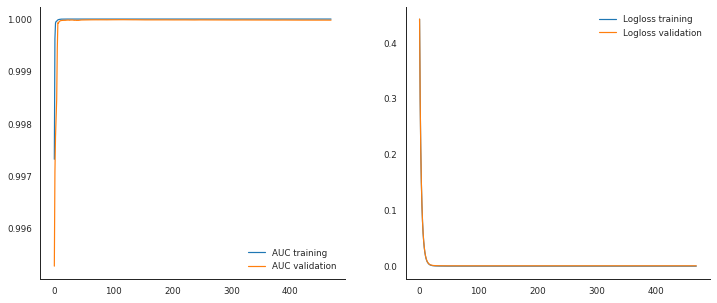

In [ ]:
# get evaluation results
evals_results_xgb_tree = clf_xgb_tree.evals_result()

# get loss and AUC by epoch
auc_train_xgb_tree, auc_val_xgb_tree, loss_train_xgb_tree, loss_val_xgb_tree, i_xgb_tree = get_xgboost_evals_results(evals_results_xgb_tree)

# plot loss and AUC
plot_model_performance(i_xgb_tree, auc_train_xgb_tree, auc_val_xgb_tree, loss_train_xgb_tree, loss_val_xgb_tree)

In [ ]:
# XGBClassifier predictions
preds_xgb_tree = clf_xgb_tree.predict(X_test)
preds_xgb_tree_train = clf_xgb_tree.predict(X_train)
preds_xgb_tree_val = clf_xgb_tree.predict(X_val)

In [ ]:
get_metrics(y_test, preds_xgb_tree)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  553539                  35
fraud (ground truth)                          54                2091

AUC on test set: 0.98738
FPR on test set: 0.00632
TPR on test set: 97.48252
FNR on test set: 2.51748
TNR on test set: 99.99368


In [ ]:
get_metrics(y_train, preds_xgb_tree_train, set_name="train")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  937637                   0
fraud (ground truth)                           0                5343

AUC on train set: 1.0
FPR on train set: 0.0
TPR on train set: 100.0
FNR on train set: 0.0
TNR on train set: 100.0


In [ ]:
get_metrics(y_val, preds_xgb_tree_val, set_name="validation")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  349060                  28
fraud (ground truth)                          19                2120

AUC on validation set: 0.99552
FPR on validation set: 0.00802
TPR on validation set: 99.11173
FNR on validation set: 0.88827
TNR on validation set: 99.99198


### Regularization

In [ ]:
def objective_xgb(trial, X_train, y_train, X_val, y_val, device):

    """
    Objective function to be used for hyperparameter tuning
    for XGBoost with Optuna.

    Input:
        trial (int): number of predefined trials during hyperparameter
                     tuning.
        X_train
        y_train
        X_val
        y_val
    Output:
        scores: f1 scores.
    """
      
    if device == "cpu":
      tree_method = "auto"
    elif device == "gpu":
      tree_method="gpu_hist"

    # xgb_param_grid = {"n_estimators": xgb_hp_tree_reg_params["n_estimators"],
    #                   "max_depth": xgb_hp_tree_reg_params["max_depth"],
    #                   "subsample": xgb_hp_tree_reg_params["subsample"],
    #                   "colsample_bytree": xgb_hp_tree_reg_params["colsample_bytree"],
    #                   "gamma": xgb_hp_tree_reg_params["gamma"],
    #                   "min_child_weight": xgb_hp_tree_reg_params["min_child_weight"],
    #                   "reg_lambda": trial.suggest_float("reg_lambda", 0, 10, step=0.001)}

    xgb_param_grid ={"n_estimators": xgb_hp_tree_params["n_estimators"],
                     "max_depth": xgb_hp_tree_params["max_depth"],
                     "subsample": xgb_hp_tree_params["subsample"],
                     "colsample_bytree": xgb_hp_tree_params["colsample_bytree"],
                     "reg_lambda": trial.suggest_float("reg_lambda", 0, 10, step=0.001)}

    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_1-logloss") # validation_1 corresponds to X_val and y_val, while validation_0 correspond to train dataset   

    model = xgb.XGBClassifier(objective="binary:logistic",
                              scale_pos_weight=scale_pos_weight,
                              use_label_encoder=False,
                              tree_method=tree_method,
                              random_state=seed_number,
                              eval_metric=["auc", "logloss"],
                              **xgb_param_grid)

    model.fit(X_train,
              y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)])
    
    return np.mean(model.evals_result()["validation_1"]["logloss"])

In [ ]:
xgb_hp_L2_reg_params, xgb_hp_L2_reg_score = tune_optuna(model="xgboost", device="gpu", study_name="XGBoost_L2_reg_params")

[I 2022-11-16 15:24:25,499] A new study created in memory with name: XGBoost_L2_reg_params


[0]	validation_0-auc:0.99530	validation_0-logloss:0.44230	validation_1-auc:0.99171	validation_1-logloss:0.44273
[1]	validation_0-auc:0.99966	validation_0-logloss:0.30047	validation_1-auc:0.99824	validation_1-logloss:0.30101
[2]	validation_0-auc:0.99980	validation_0-logloss:0.21077	validation_1-auc:0.99834	validation_1-logloss:0.21141
[3]	validation_0-auc:0.99983	validation_0-logloss:0.15108	validation_1-auc:0.99817	validation_1-logloss:0.15168
[4]	validation_0-auc:0.99983	validation_0-logloss:0.10959	validation_1-auc:0.99851	validation_1-logloss:0.11020
[5]	validation_0-auc:0.99998	validation_0-logloss:0.07995	validation_1-auc:0.99945	validation_1-logloss:0.08053
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05908	validation_1-auc:0.99946	validation_1-logloss:0.05969
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04435	validation_1-auc:0.99946	validation_1-logloss:0.04495
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03318	validation_1-auc:0.99993	validation_1-logloss:

[I 2022-11-16 15:24:36,829] Trial 0 finished with value: 0.003880481376827019 and parameters: {'reg_lambda': 3.745}. Best is trial 0 with value: 0.003880481376827019.


[0]	validation_0-auc:0.99667	validation_0-logloss:0.44281	validation_1-auc:0.99474	validation_1-logloss:0.44322
[1]	validation_0-auc:0.99948	validation_0-logloss:0.30120	validation_1-auc:0.99817	validation_1-logloss:0.30172
[2]	validation_0-auc:0.99976	validation_0-logloss:0.21139	validation_1-auc:0.99840	validation_1-logloss:0.21200
[3]	validation_0-auc:0.99977	validation_0-logloss:0.15177	validation_1-auc:0.99850	validation_1-logloss:0.15245
[4]	validation_0-auc:0.99977	validation_0-logloss:0.11035	validation_1-auc:0.99894	validation_1-logloss:0.11104
[5]	validation_0-auc:0.99998	validation_0-logloss:0.08070	validation_1-auc:0.99990	validation_1-logloss:0.08136
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05951	validation_1-auc:0.99993	validation_1-logloss:0.06019
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04488	validation_1-auc:0.99993	validation_1-logloss:0.04553
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03346	validation_1-auc:0.99995	validation_1-logloss:

[I 2022-11-16 15:24:47,917] Trial 1 finished with value: 0.0038646765848674926 and parameters: {'reg_lambda': 9.508000000000001}. Best is trial 1 with value: 0.0038646765848674926.


[0]	validation_0-auc:0.99646	validation_0-logloss:0.44276	validation_1-auc:0.99449	validation_1-logloss:0.44319
[1]	validation_0-auc:0.99949	validation_0-logloss:0.30107	validation_1-auc:0.99791	validation_1-logloss:0.30162
[2]	validation_0-auc:0.99976	validation_0-logloss:0.21126	validation_1-auc:0.99837	validation_1-logloss:0.21189
[3]	validation_0-auc:0.99977	validation_0-logloss:0.15154	validation_1-auc:0.99897	validation_1-logloss:0.15215
[4]	validation_0-auc:0.99977	validation_0-logloss:0.11013	validation_1-auc:0.99940	validation_1-logloss:0.11076
[5]	validation_0-auc:0.99996	validation_0-logloss:0.08080	validation_1-auc:0.99944	validation_1-logloss:0.08149
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05946	validation_1-auc:0.99992	validation_1-logloss:0.06013
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04481	validation_1-auc:0.99992	validation_1-logloss:0.04548
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03355	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:24:58,905] Trial 2 finished with value: 0.0038739622832819755 and parameters: {'reg_lambda': 7.32}. Best is trial 1 with value: 0.0038646765848674926.


[0]	validation_0-auc:0.99626	validation_0-logloss:0.44262	validation_1-auc:0.99396	validation_1-logloss:0.44305
[1]	validation_0-auc:0.99952	validation_0-logloss:0.30092	validation_1-auc:0.99794	validation_1-logloss:0.30147
[2]	validation_0-auc:0.99977	validation_0-logloss:0.21114	validation_1-auc:0.99814	validation_1-logloss:0.21177
[3]	validation_0-auc:0.99979	validation_0-logloss:0.15142	validation_1-auc:0.99899	validation_1-logloss:0.15202
[4]	validation_0-auc:0.99978	validation_0-logloss:0.10997	validation_1-auc:0.99942	validation_1-logloss:0.11061
[5]	validation_0-auc:0.99997	validation_0-logloss:0.08078	validation_1-auc:0.99945	validation_1-logloss:0.08146
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05943	validation_1-auc:0.99992	validation_1-logloss:0.06011
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04470	validation_1-auc:0.99993	validation_1-logloss:0.04535
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03324	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:25:09,977] Trial 3 finished with value: 0.0038627557481233296 and parameters: {'reg_lambda': 5.987}. Best is trial 3 with value: 0.0038627557481233296.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.44178	validation_1-auc:0.99532	validation_1-logloss:0.44215
[1]	validation_0-auc:0.99963	validation_0-logloss:0.29992	validation_1-auc:0.99757	validation_1-logloss:0.30040
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21033	validation_1-auc:0.99774	validation_1-logloss:0.21092
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15066	validation_1-auc:0.99861	validation_1-logloss:0.15122
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10925	validation_1-auc:0.99896	validation_1-logloss:0.10982
[5]	validation_0-auc:0.99998	validation_0-logloss:0.07964	validation_1-auc:0.99946	validation_1-logloss:0.08023
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05879	validation_1-auc:0.99993	validation_1-logloss:0.05941
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04408	validation_1-auc:0.99992	validation_1-logloss:0.04472
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03292	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:25:20,565] Trial 4 finished with value: 0.0038471627300071232 and parameters: {'reg_lambda': 1.56}. Best is trial 4 with value: 0.0038471627300071232.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.44178	validation_1-auc:0.99532	validation_1-logloss:0.44215
[1]	validation_0-auc:0.99963	validation_0-logloss:0.29992	validation_1-auc:0.99757	validation_1-logloss:0.30040
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21033	validation_1-auc:0.99774	validation_1-logloss:0.21092
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15066	validation_1-auc:0.99861	validation_1-logloss:0.15122
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10925	validation_1-auc:0.99896	validation_1-logloss:0.10982
[5]	validation_0-auc:0.99998	validation_0-logloss:0.07964	validation_1-auc:0.99946	validation_1-logloss:0.08023
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05879	validation_1-auc:0.99993	validation_1-logloss:0.05941
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04408	validation_1-auc:0.99992	validation_1-logloss:0.04472
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03292	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:25:31,217] Trial 5 finished with value: 0.0038471627300071232 and parameters: {'reg_lambda': 1.56}. Best is trial 4 with value: 0.0038471627300071232.


[0]	validation_0-auc:0.99731	validation_0-logloss:0.44163	validation_1-auc:0.99526	validation_1-logloss:0.44200
[1]	validation_0-auc:0.99962	validation_0-logloss:0.29965	validation_1-auc:0.99710	validation_1-logloss:0.30012
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21011	validation_1-auc:0.99725	validation_1-logloss:0.21069
[3]	validation_0-auc:0.99996	validation_0-logloss:0.15046	validation_1-auc:0.99814	validation_1-logloss:0.15102
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10920	validation_1-auc:0.99852	validation_1-logloss:0.10981
[5]	validation_0-auc:0.99999	validation_0-logloss:0.07955	validation_1-auc:0.99945	validation_1-logloss:0.08016
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05878	validation_1-auc:0.99991	validation_1-logloss:0.05943
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04400	validation_1-auc:0.99990	validation_1-logloss:0.04467
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03278	validation_1-auc:0.99995	validation_1-logloss:

[I 2022-11-16 15:25:41,726] Trial 6 finished with value: 0.0038154648619181876 and parameters: {'reg_lambda': 0.58}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99645	validation_0-logloss:0.44274	validation_1-auc:0.99452	validation_1-logloss:0.44314
[1]	validation_0-auc:0.99949	validation_0-logloss:0.30113	validation_1-auc:0.99792	validation_1-logloss:0.30164
[2]	validation_0-auc:0.99976	validation_0-logloss:0.21132	validation_1-auc:0.99838	validation_1-logloss:0.21193
[3]	validation_0-auc:0.99977	validation_0-logloss:0.15170	validation_1-auc:0.99850	validation_1-logloss:0.15238
[4]	validation_0-auc:0.99977	validation_0-logloss:0.11029	validation_1-auc:0.99894	validation_1-logloss:0.11097
[5]	validation_0-auc:0.99998	validation_0-logloss:0.08064	validation_1-auc:0.99990	validation_1-logloss:0.08130
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05945	validation_1-auc:0.99992	validation_1-logloss:0.06013
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04484	validation_1-auc:0.99993	validation_1-logloss:0.04548
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03341	validation_1-auc:0.99995	validation_1-logloss:

[I 2022-11-16 15:25:53,289] Trial 7 finished with value: 0.003853713884180542 and parameters: {'reg_lambda': 8.662}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99646	validation_0-logloss:0.44262	validation_1-auc:0.99449	validation_1-logloss:0.44305
[1]	validation_0-auc:0.99952	validation_0-logloss:0.30093	validation_1-auc:0.99795	validation_1-logloss:0.30147
[2]	validation_0-auc:0.99977	validation_0-logloss:0.21114	validation_1-auc:0.99814	validation_1-logloss:0.21177
[3]	validation_0-auc:0.99979	validation_0-logloss:0.15142	validation_1-auc:0.99899	validation_1-logloss:0.15203
[4]	validation_0-auc:0.99978	validation_0-logloss:0.10998	validation_1-auc:0.99942	validation_1-logloss:0.11061
[5]	validation_0-auc:0.99997	validation_0-logloss:0.08078	validation_1-auc:0.99945	validation_1-logloss:0.08146
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05943	validation_1-auc:0.99992	validation_1-logloss:0.06012
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04470	validation_1-auc:0.99993	validation_1-logloss:0.04536
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03324	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:26:04,727] Trial 8 finished with value: 0.0038519728465847094 and parameters: {'reg_lambda': 6.011}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99646	validation_0-logloss:0.44274	validation_1-auc:0.99449	validation_1-logloss:0.44316
[1]	validation_0-auc:0.99949	validation_0-logloss:0.30104	validation_1-auc:0.99791	validation_1-logloss:0.30159
[2]	validation_0-auc:0.99976	validation_0-logloss:0.21124	validation_1-auc:0.99837	validation_1-logloss:0.21187
[3]	validation_0-auc:0.99977	validation_0-logloss:0.15152	validation_1-auc:0.99897	validation_1-logloss:0.15213
[4]	validation_0-auc:0.99977	validation_0-logloss:0.11011	validation_1-auc:0.99940	validation_1-logloss:0.11074
[5]	validation_0-auc:0.99996	validation_0-logloss:0.08078	validation_1-auc:0.99944	validation_1-logloss:0.08147
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05947	validation_1-auc:0.99993	validation_1-logloss:0.06015
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04480	validation_1-auc:0.99992	validation_1-logloss:0.04548
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03350	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:26:16,174] Trial 9 finished with value: 0.003883708005045437 and parameters: {'reg_lambda': 7.081}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99728	validation_0-logloss:0.44156	validation_1-auc:0.99518	validation_1-logloss:0.44194
[1]	validation_0-auc:0.99962	validation_0-logloss:0.29956	validation_1-auc:0.99744	validation_1-logloss:0.30003
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21002	validation_1-auc:0.99808	validation_1-logloss:0.21060
[3]	validation_0-auc:0.99996	validation_0-logloss:0.15036	validation_1-auc:0.99763	validation_1-logloss:0.15092
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10908	validation_1-auc:0.99802	validation_1-logloss:0.10969
[5]	validation_0-auc:0.99997	validation_0-logloss:0.07946	validation_1-auc:0.99941	validation_1-logloss:0.08009
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05872	validation_1-auc:0.99987	validation_1-logloss:0.05938
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04388	validation_1-auc:0.99987	validation_1-logloss:0.04457
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03264	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:26:26,911] Trial 10 finished with value: 0.0038971078178024945 and parameters: {'reg_lambda': 0.20500000000000002}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99667	validation_0-logloss:0.44283	validation_1-auc:0.99474	validation_1-logloss:0.44324
[1]	validation_0-auc:0.99948	validation_0-logloss:0.30122	validation_1-auc:0.99817	validation_1-logloss:0.30173
[2]	validation_0-auc:0.99976	validation_0-logloss:0.21150	validation_1-auc:0.99840	validation_1-logloss:0.21212
[3]	validation_0-auc:0.99977	validation_0-logloss:0.15191	validation_1-auc:0.99849	validation_1-logloss:0.15256
[4]	validation_0-auc:0.99978	validation_0-logloss:0.11041	validation_1-auc:0.99937	validation_1-logloss:0.11107
[5]	validation_0-auc:0.99998	validation_0-logloss:0.08071	validation_1-auc:0.99989	validation_1-logloss:0.08134
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05952	validation_1-auc:0.99992	validation_1-logloss:0.06017
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04494	validation_1-auc:0.99991	validation_1-logloss:0.04556
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03350	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:26:38,604] Trial 11 finished with value: 0.0038888718805211017 and parameters: {'reg_lambda': 9.700000000000001}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99645	validation_0-logloss:0.44270	validation_1-auc:0.99452	validation_1-logloss:0.44311
[1]	validation_0-auc:0.99949	validation_0-logloss:0.30109	validation_1-auc:0.99791	validation_1-logloss:0.30160
[2]	validation_0-auc:0.99976	validation_0-logloss:0.21129	validation_1-auc:0.99838	validation_1-logloss:0.21189
[3]	validation_0-auc:0.99977	validation_0-logloss:0.15158	validation_1-auc:0.99897	validation_1-logloss:0.15217
[4]	validation_0-auc:0.99977	validation_0-logloss:0.11019	validation_1-auc:0.99941	validation_1-logloss:0.11081
[5]	validation_0-auc:0.99996	validation_0-logloss:0.08087	validation_1-auc:0.99945	validation_1-logloss:0.08154
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05957	validation_1-auc:0.99992	validation_1-logloss:0.06024
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04491	validation_1-auc:0.99992	validation_1-logloss:0.04558
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03367	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:26:50,235] Trial 12 finished with value: 0.003889776602620291 and parameters: {'reg_lambda': 8.325}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99733	validation_0-logloss:0.44185	validation_1-auc:0.99534	validation_1-logloss:0.44223
[1]	validation_0-auc:0.99963	validation_0-logloss:0.30001	validation_1-auc:0.99782	validation_1-logloss:0.30050
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21041	validation_1-auc:0.99846	validation_1-logloss:0.21100
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15071	validation_1-auc:0.99809	validation_1-logloss:0.15128
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10929	validation_1-auc:0.99849	validation_1-logloss:0.10987
[5]	validation_0-auc:0.99998	validation_0-logloss:0.07972	validation_1-auc:0.99945	validation_1-logloss:0.08031
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05886	validation_1-auc:0.99993	validation_1-logloss:0.05949
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04415	validation_1-auc:0.99992	validation_1-logloss:0.04477
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03293	validation_1-auc:0.99995	validation_1-logloss:

[I 2022-11-16 15:27:01,433] Trial 13 finished with value: 0.003870981884082041 and parameters: {'reg_lambda': 2.123}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.44181	validation_1-auc:0.99532	validation_1-logloss:0.44219
[1]	validation_0-auc:0.99963	validation_0-logloss:0.29997	validation_1-auc:0.99760	validation_1-logloss:0.30045
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21037	validation_1-auc:0.99816	validation_1-logloss:0.21095
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15069	validation_1-auc:0.99900	validation_1-logloss:0.15125
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10927	validation_1-auc:0.99898	validation_1-logloss:0.10984
[5]	validation_0-auc:0.99998	validation_0-logloss:0.07966	validation_1-auc:0.99946	validation_1-logloss:0.08025
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05881	validation_1-auc:0.99993	validation_1-logloss:0.05944
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04412	validation_1-auc:0.99992	validation_1-logloss:0.04476
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03290	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:27:12,645] Trial 14 finished with value: 0.0038741972319406076 and parameters: {'reg_lambda': 1.818}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.44181	validation_1-auc:0.99532	validation_1-logloss:0.44219
[1]	validation_0-auc:0.99963	validation_0-logloss:0.29997	validation_1-auc:0.99760	validation_1-logloss:0.30045
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21037	validation_1-auc:0.99816	validation_1-logloss:0.21095
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15069	validation_1-auc:0.99900	validation_1-logloss:0.15125
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10927	validation_1-auc:0.99898	validation_1-logloss:0.10985
[5]	validation_0-auc:0.99998	validation_0-logloss:0.07967	validation_1-auc:0.99946	validation_1-logloss:0.08026
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05881	validation_1-auc:0.99993	validation_1-logloss:0.05944
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04412	validation_1-auc:0.99992	validation_1-logloss:0.04476
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03290	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:27:24,073] Trial 15 finished with value: 0.003858195641865359 and parameters: {'reg_lambda': 1.834}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99723	validation_0-logloss:0.44205	validation_1-auc:0.99531	validation_1-logloss:0.44243
[1]	validation_0-auc:0.99978	validation_0-logloss:0.30022	validation_1-auc:0.99828	validation_1-logloss:0.30072
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21059	validation_1-auc:0.99849	validation_1-logloss:0.21119
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15093	validation_1-auc:0.99809	validation_1-logloss:0.15150
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10947	validation_1-auc:0.99836	validation_1-logloss:0.11005
[5]	validation_0-auc:0.99998	validation_0-logloss:0.07985	validation_1-auc:0.99945	validation_1-logloss:0.08043
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05876	validation_1-auc:0.99993	validation_1-logloss:0.05937
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04415	validation_1-auc:0.99993	validation_1-logloss:0.04475
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03293	validation_1-auc:0.99995	validation_1-logloss:

[I 2022-11-16 15:27:35,577] Trial 16 finished with value: 0.003877078457559697 and parameters: {'reg_lambda': 3.0420000000000003}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99560	validation_0-logloss:0.44253	validation_1-auc:0.99229	validation_1-logloss:0.44296
[1]	validation_0-auc:0.99964	validation_0-logloss:0.30068	validation_1-auc:0.99832	validation_1-logloss:0.30122
[2]	validation_0-auc:0.99978	validation_0-logloss:0.21096	validation_1-auc:0.99845	validation_1-logloss:0.21159
[3]	validation_0-auc:0.99980	validation_0-logloss:0.15128	validation_1-auc:0.99902	validation_1-logloss:0.15188
[4]	validation_0-auc:0.99980	validation_0-logloss:0.10981	validation_1-auc:0.99941	validation_1-logloss:0.11043
[5]	validation_0-auc:0.99997	validation_0-logloss:0.08061	validation_1-auc:0.99945	validation_1-logloss:0.08126
[6]	validation_0-auc:0.99998	validation_0-logloss:0.05929	validation_1-auc:0.99993	validation_1-logloss:0.05994
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04458	validation_1-auc:0.99993	validation_1-logloss:0.04520
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03330	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:27:47,214] Trial 17 finished with value: 0.003869551523061114 and parameters: {'reg_lambda': 5.248}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99518	validation_0-logloss:0.44237	validation_1-auc:0.99148	validation_1-logloss:0.44281
[1]	validation_0-auc:0.99962	validation_0-logloss:0.30054	validation_1-auc:0.99803	validation_1-logloss:0.30109
[2]	validation_0-auc:0.99977	validation_0-logloss:0.21084	validation_1-auc:0.99845	validation_1-logloss:0.21147
[3]	validation_0-auc:0.99980	validation_0-logloss:0.15114	validation_1-auc:0.99856	validation_1-logloss:0.15174
[4]	validation_0-auc:0.99980	validation_0-logloss:0.10970	validation_1-auc:0.99897	validation_1-logloss:0.11031
[5]	validation_0-auc:0.99998	validation_0-logloss:0.08004	validation_1-auc:0.99945	validation_1-logloss:0.08063
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05914	validation_1-auc:0.99947	validation_1-logloss:0.05975
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04442	validation_1-auc:0.99946	validation_1-logloss:0.04502
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03324	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:27:58,807] Trial 18 finished with value: 0.003846039243035539 and parameters: {'reg_lambda': 4.319}. Best is trial 6 with value: 0.0038154648619181876.


[0]	validation_0-auc:0.99733	validation_0-logloss:0.44196	validation_1-auc:0.99538	validation_1-logloss:0.44234
[1]	validation_0-auc:0.99978	validation_0-logloss:0.30013	validation_1-auc:0.99826	validation_1-logloss:0.30062
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21052	validation_1-auc:0.99848	validation_1-logloss:0.21111
[3]	validation_0-auc:0.99995	validation_0-logloss:0.15086	validation_1-auc:0.99809	validation_1-logloss:0.15142
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10941	validation_1-auc:0.99847	validation_1-logloss:0.10998
[5]	validation_0-auc:0.99999	validation_0-logloss:0.07980	validation_1-auc:0.99945	validation_1-logloss:0.08037
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05888	validation_1-auc:0.99946	validation_1-logloss:0.05944
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04421	validation_1-auc:0.99946	validation_1-logloss:0.04478
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03302	validation_1-auc:0.99994	validation_1-logloss:

[I 2022-11-16 15:28:10,187] Trial 19 finished with value: 0.0038388115419276526 and parameters: {'reg_lambda': 2.912}. Best is trial 6 with value: 0.0038154648619181876.


In [ ]:
for keys, values in xgb_hp_L2_reg_params.items():
    xgb_hp_L2_reg_params = values

print(xgb_hp_L2_reg_params)
print(xgb_hp_L2_reg_score)

{'reg_lambda': 0.58}
{<built-in function bin>: 0.0038154648619181876}


In [ ]:
xgb_hp_tree_L2_reg_params = xgb_hp_tree_params.copy()
xgb_hp_tree_L2_reg_params.update(xgb_hp_L2_reg_params)
xgb_hp_tree_L2_reg_params

{'n_estimators': 470,
 'max_depth': 11,
 'subsample': 0.7,
 'colsample_bytree': 0.9,
 'reg_lambda': 0.58}

In [ ]:
clf_xgb_L2_reg = xgb.XGBClassifier(objective="binary:logistic",
                                   scale_pos_weight=scale_pos_weight,
                                   use_label_encoder=False,
                                   tree_method="gpu_hist",
                                   random_state=seed_number,
                                   eval_metric=["auc", "logloss"]).set_params(**xgb_hp_tree_L2_reg_params)

clf_xgb_L2_reg.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   verbose=True)

[0]	validation_0-auc:0.99731	validation_0-logloss:0.44163	validation_1-auc:0.99526	validation_1-logloss:0.44200
[1]	validation_0-auc:0.99962	validation_0-logloss:0.29965	validation_1-auc:0.99710	validation_1-logloss:0.30012
[2]	validation_0-auc:0.99993	validation_0-logloss:0.21011	validation_1-auc:0.99725	validation_1-logloss:0.21069
[3]	validation_0-auc:0.99996	validation_0-logloss:0.15046	validation_1-auc:0.99814	validation_1-logloss:0.15102
[4]	validation_0-auc:0.99996	validation_0-logloss:0.10920	validation_1-auc:0.99852	validation_1-logloss:0.10981
[5]	validation_0-auc:0.99999	validation_0-logloss:0.07955	validation_1-auc:0.99945	validation_1-logloss:0.08016
[6]	validation_0-auc:0.99999	validation_0-logloss:0.05878	validation_1-auc:0.99991	validation_1-logloss:0.05943
[7]	validation_0-auc:0.99999	validation_0-logloss:0.04400	validation_1-auc:0.99990	validation_1-logloss:0.04467
[8]	validation_0-auc:0.99999	validation_0-logloss:0.03278	validation_1-auc:0.99995	validation_1-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['auc', 'logloss'], gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=11,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=470, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0.58, ...)

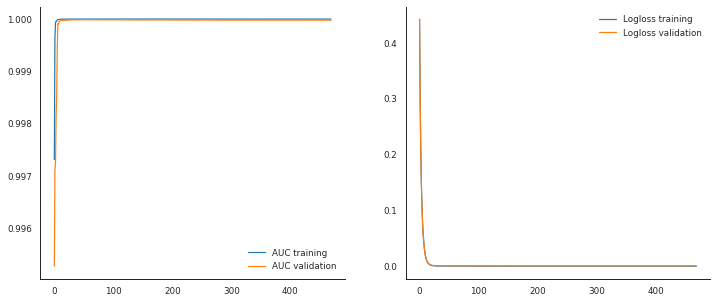

In [ ]:
# get evaluation results
evals_results_xgb_L2_reg = clf_xgb_L2_reg.evals_result()

# get loss and AUC by epoch
auc_train_xgb_L2_reg, auc_val_xgb_L2_reg, loss_train_xgb_L2_reg, loss_val_xgb_L2_reg, i_xgb_L2_reg = get_xgboost_evals_results(evals_results_xgb_L2_reg)

# plot loss and AUC
plot_model_performance(i_xgb_L2_reg, auc_train_xgb_L2_reg, auc_val_xgb_L2_reg, loss_train_xgb_L2_reg, loss_val_xgb_L2_reg)

In [ ]:
# XGBClassifier predictions
preds_xgb_L2_reg = clf_xgb_L2_reg.predict(X_test)
preds_xgb_L2_reg_train = clf_xgb_L2_reg.predict(X_train)
preds_xgb_L2_reg_val = clf_xgb_L2_reg.predict(X_val)

In [ ]:
get_metrics(y_test, preds_xgb_L2_reg)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  553537                  37
fraud (ground truth)                          52                2093

AUC on test set: 0.98785
FPR on test set: 0.00668
TPR on test set: 97.57576
FNR on test set: 2.42424
TNR on test set: 99.99332


In [ ]:
get_metrics(y_train, preds_xgb_L2_reg_train, set_name="train")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  937637                   0
fraud (ground truth)                           0                5343

AUC on train set: 1.0
FPR on train set: 0.0
TPR on train set: 100.0
FNR on train set: 0.0
TNR on train set: 100.0


In [ ]:
get_metrics(y_val, preds_xgb_L2_reg_val, set_name="validation")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  349052                  36
fraud (ground truth)                          20                2119

AUC on validation set: 0.99527
FPR on validation set: 0.01031
TPR on validation set: 99.06498
FNR on validation set: 0.93502
TNR on validation set: 99.98969


### Learning rate

In [ ]:
def objective_xgb(trial, X_train, y_train, X_val, y_val, device):

    """
    Objective function to be used for hyperparameter tuning
    for XGBoost with Optuna.

    Input:
        trial (int): number of predefined trials during hyperparameter
                     tuning.
        X_train
        y_train
        X_val
        y_val
    Output:
        scores: f1 scores.
    """
      
    if device == "cpu":
      tree_method = "auto"
    elif device == "gpu":
      tree_method="gpu_hist"

    xgb_param_grid = {"n_estimators": xgb_hp_tree_params["n_estimators"],
                      "max_depth": xgb_hp_tree_params["max_depth"],
                      "subsample": xgb_hp_tree_params["subsample"],
                      "colsample_bytree": xgb_hp_tree_params["colsample_bytree"],
                      "learning_rate": trial.suggest_float("learning_rate", .0001, 0.1, log=True)}

    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_1-logloss") # validation_1 corresponds to X_val and y_val, while validation_0 correspond to train dataset   

    model = xgb.XGBClassifier(objective="binary:logistic",
                              scale_pos_weight=scale_pos_weight,
                              use_label_encoder=False,
                              tree_method=tree_method,
                              random_state=seed_number,
                              eval_metric=["auc", "logloss"],
                              **xgb_param_grid)

    model.fit(X_train,
              y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)])
    
    return np.mean(model.evals_result()["validation_1"]["logloss"])

In [ ]:
xgb_hp_lr_params, xgb_hp_lr_score = tune_optuna(model="xgboost", device="gpu", study_name="XGBoost_lr_params")

[I 2022-11-16 15:33:42,893] A new study created in memory with name: XGBoost_lr_params


[0]	validation_0-auc:0.99724	validation_0-logloss:0.69184	validation_1-auc:0.99511	validation_1-logloss:0.69184
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69052	validation_1-auc:0.99897	validation_1-logloss:0.69052
[2]	validation_0-auc:0.99989	validation_0-logloss:0.68920	validation_1-auc:0.99949	validation_1-logloss:0.68921
[3]	validation_0-auc:0.99993	validation_0-logloss:0.68789	validation_1-auc:0.99965	validation_1-logloss:0.68790
[4]	validation_0-auc:0.99995	validation_0-logloss:0.68658	validation_1-auc:0.99984	validation_1-logloss:0.68659
[5]	validation_0-auc:0.99996	validation_0-logloss:0.68528	validation_1-auc:0.99984	validation_1-logloss:0.68528
[6]	validation_0-auc:0.99996	validation_0-logloss:0.68398	validation_1-auc:0.99986	validation_1-logloss:0.68398
[7]	validation_0-auc:0.99997	validation_0-logloss:0.68272	validation_1-auc:0.99975	validation_1-logloss:0.68273
[8]	validation_0-auc:0.99997	validation_0-logloss:0.68142	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:33:57,803] Trial 0 finished with value: 0.47165502847004986 and parameters: {'learning_rate': 0.0013292918943162175}. Best is trial 0 with value: 0.47165502847004986.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.62557	validation_1-auc:0.99527	validation_1-logloss:0.62566
[1]	validation_0-auc:0.99982	validation_0-logloss:0.56625	validation_1-auc:0.99837	validation_1-logloss:0.56639
[2]	validation_0-auc:0.99993	validation_0-logloss:0.51416	validation_1-auc:0.99887	validation_1-logloss:0.51432
[3]	validation_0-auc:0.99995	validation_0-logloss:0.46831	validation_1-auc:0.99897	validation_1-logloss:0.46852
[4]	validation_0-auc:0.99996	validation_0-logloss:0.42755	validation_1-auc:0.99986	validation_1-logloss:0.42779
[5]	validation_0-auc:0.99997	validation_0-logloss:0.39115	validation_1-auc:0.99986	validation_1-logloss:0.39143
[6]	validation_0-auc:0.99997	validation_0-logloss:0.35850	validation_1-auc:0.99942	validation_1-logloss:0.35881
[7]	validation_0-auc:0.99998	validation_0-logloss:0.33011	validation_1-auc:0.99981	validation_1-logloss:0.33048
[8]	validation_0-auc:0.99998	validation_0-logloss:0.30344	validation_1-auc:0.99981	validation_1-logloss:

[I 2022-11-16 15:34:10,955] Trial 1 finished with value: 0.017234449855148763 and parameters: {'learning_rate': 0.07114476009343425}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.67780	validation_1-auc:0.99527	validation_1-logloss:0.67782
[1]	validation_0-auc:0.99976	validation_0-logloss:0.66277	validation_1-auc:0.99919	validation_1-logloss:0.66281
[2]	validation_0-auc:0.99990	validation_0-logloss:0.64819	validation_1-auc:0.99952	validation_1-logloss:0.64823
[3]	validation_0-auc:0.99993	validation_0-logloss:0.63404	validation_1-auc:0.99960	validation_1-logloss:0.63410
[4]	validation_0-auc:0.99996	validation_0-logloss:0.62030	validation_1-auc:0.99984	validation_1-logloss:0.62037
[5]	validation_0-auc:0.99996	validation_0-logloss:0.60698	validation_1-auc:0.99984	validation_1-logloss:0.60706
[6]	validation_0-auc:0.99997	validation_0-logloss:0.59402	validation_1-auc:0.99986	validation_1-logloss:0.59411
[7]	validation_0-auc:0.99998	validation_0-logloss:0.58186	validation_1-auc:0.99976	validation_1-logloss:0.58199
[8]	validation_0-auc:0.99998	validation_0-logloss:0.56962	validation_1-auc:0.99976	validation_1-logloss:

[I 2022-11-16 15:34:26,159] Trial 2 finished with value: 0.07945540053693054 and parameters: {'learning_rate': 0.015702970884055395}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.68701	validation_1-auc:0.99527	validation_1-logloss:0.68702
[1]	validation_0-auc:0.99977	validation_0-logloss:0.68088	validation_1-auc:0.99916	validation_1-logloss:0.68090
[2]	validation_0-auc:0.99989	validation_0-logloss:0.67483	validation_1-auc:0.99950	validation_1-logloss:0.67485
[3]	validation_0-auc:0.99993	validation_0-logloss:0.66885	validation_1-auc:0.99964	validation_1-logloss:0.66887
[4]	validation_0-auc:0.99995	validation_0-logloss:0.66294	validation_1-auc:0.99984	validation_1-logloss:0.66297
[5]	validation_0-auc:0.99996	validation_0-logloss:0.65711	validation_1-auc:0.99984	validation_1-logloss:0.65714
[6]	validation_0-auc:0.99996	validation_0-logloss:0.65134	validation_1-auc:0.99984	validation_1-logloss:0.65137
[7]	validation_0-auc:0.99997	validation_0-logloss:0.64583	validation_1-auc:0.99975	validation_1-logloss:0.64589
[8]	validation_0-auc:0.99997	validation_0-logloss:0.64019	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:34:41,227] Trial 3 finished with value: 0.19031471432706246 and parameters: {'learning_rate': 0.006251373574521752}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99727	validation_0-logloss:0.69286	validation_1-auc:0.99513	validation_1-logloss:0.69286
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69257	validation_1-auc:0.99926	validation_1-logloss:0.69257
[2]	validation_0-auc:0.99989	validation_0-logloss:0.69227	validation_1-auc:0.99943	validation_1-logloss:0.69227
[3]	validation_0-auc:0.99993	validation_0-logloss:0.69198	validation_1-auc:0.99964	validation_1-logloss:0.69198
[4]	validation_0-auc:0.99995	validation_0-logloss:0.69169	validation_1-auc:0.99984	validation_1-logloss:0.69169
[5]	validation_0-auc:0.99996	validation_0-logloss:0.69140	validation_1-auc:0.99984	validation_1-logloss:0.69140
[6]	validation_0-auc:0.99996	validation_0-logloss:0.69111	validation_1-auc:0.99986	validation_1-logloss:0.69111
[7]	validation_0-auc:0.99997	validation_0-logloss:0.69082	validation_1-auc:0.99975	validation_1-logloss:0.69083
[8]	validation_0-auc:0.99997	validation_0-logloss:0.69053	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:34:55,812] Trial 4 finished with value: 0.6301637038809772 and parameters: {'learning_rate': 0.00029380279387035364}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99700	validation_0-logloss:0.69286	validation_1-auc:0.99467	validation_1-logloss:0.69286
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69257	validation_1-auc:0.99904	validation_1-logloss:0.69257
[2]	validation_0-auc:0.99989	validation_0-logloss:0.69227	validation_1-auc:0.99944	validation_1-logloss:0.69227
[3]	validation_0-auc:0.99993	validation_0-logloss:0.69198	validation_1-auc:0.99950	validation_1-logloss:0.69198
[4]	validation_0-auc:0.99995	validation_0-logloss:0.69169	validation_1-auc:0.99984	validation_1-logloss:0.69169
[5]	validation_0-auc:0.99996	validation_0-logloss:0.69140	validation_1-auc:0.99984	validation_1-logloss:0.69140
[6]	validation_0-auc:0.99996	validation_0-logloss:0.69111	validation_1-auc:0.99986	validation_1-logloss:0.69111
[7]	validation_0-auc:0.99997	validation_0-logloss:0.69083	validation_1-auc:0.99975	validation_1-logloss:0.69083
[8]	validation_0-auc:0.99997	validation_0-logloss:0.69053	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:35:10,572] Trial 5 finished with value: 0.6301733848595176 and parameters: {'learning_rate': 0.00029375384576328325}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99710	validation_0-logloss:0.69300	validation_1-auc:0.99476	validation_1-logloss:0.69300
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69285	validation_1-auc:0.99907	validation_1-logloss:0.69285
[2]	validation_0-auc:0.99988	validation_0-logloss:0.69270	validation_1-auc:0.99941	validation_1-logloss:0.69270
[3]	validation_0-auc:0.99993	validation_0-logloss:0.69255	validation_1-auc:0.99952	validation_1-logloss:0.69255
[4]	validation_0-auc:0.99994	validation_0-logloss:0.69241	validation_1-auc:0.99982	validation_1-logloss:0.69241
[5]	validation_0-auc:0.99995	validation_0-logloss:0.69226	validation_1-auc:0.99983	validation_1-logloss:0.69226
[6]	validation_0-auc:0.99996	validation_0-logloss:0.69211	validation_1-auc:0.99985	validation_1-logloss:0.69211
[7]	validation_0-auc:0.99997	validation_0-logloss:0.69197	validation_1-auc:0.99974	validation_1-logloss:0.69197
[8]	validation_0-auc:0.99997	validation_0-logloss:0.69182	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:35:25,191] Trial 6 finished with value: 0.6597663691108475 and parameters: {'learning_rate': 0.00014936568554617635}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.65484	validation_1-auc:0.99527	validation_1-logloss:0.65489
[1]	validation_0-auc:0.99976	validation_0-logloss:0.61907	validation_1-auc:0.99872	validation_1-logloss:0.61915
[2]	validation_0-auc:0.99990	validation_0-logloss:0.58585	validation_1-auc:0.99906	validation_1-logloss:0.58594
[3]	validation_0-auc:0.99994	validation_0-logloss:0.55504	validation_1-auc:0.99940	validation_1-logloss:0.55517
[4]	validation_0-auc:0.99996	validation_0-logloss:0.52632	validation_1-auc:0.99986	validation_1-logloss:0.52647
[5]	validation_0-auc:0.99996	validation_0-logloss:0.49953	validation_1-auc:0.99986	validation_1-logloss:0.49971
[6]	validation_0-auc:0.99997	validation_0-logloss:0.47445	validation_1-auc:0.99987	validation_1-logloss:0.47465
[7]	validation_0-auc:0.99997	validation_0-logloss:0.45179	validation_1-auc:0.99976	validation_1-logloss:0.45206
[8]	validation_0-auc:0.99998	validation_0-logloss:0.42970	validation_1-auc:0.99976	validation_1-logloss:

[I 2022-11-16 15:35:39,079] Trial 7 finished with value: 0.0312558845661842 and parameters: {'learning_rate': 0.0396760507705299}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99733	validation_0-logloss:0.68690	validation_1-auc:0.99530	validation_1-logloss:0.68691
[1]	validation_0-auc:0.99977	validation_0-logloss:0.68068	validation_1-auc:0.99922	validation_1-logloss:0.68069
[2]	validation_0-auc:0.99989	validation_0-logloss:0.67452	validation_1-auc:0.99950	validation_1-logloss:0.67454
[3]	validation_0-auc:0.99993	validation_0-logloss:0.66844	validation_1-auc:0.99965	validation_1-logloss:0.66847
[4]	validation_0-auc:0.99995	validation_0-logloss:0.66244	validation_1-auc:0.99984	validation_1-logloss:0.66247
[5]	validation_0-auc:0.99996	validation_0-logloss:0.65651	validation_1-auc:0.99984	validation_1-logloss:0.65654
[6]	validation_0-auc:0.99996	validation_0-logloss:0.65065	validation_1-auc:0.99984	validation_1-logloss:0.65069
[7]	validation_0-auc:0.99997	validation_0-logloss:0.64506	validation_1-auc:0.99975	validation_1-logloss:0.64511
[8]	validation_0-auc:0.99997	validation_0-logloss:0.63934	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:35:54,139] Trial 8 finished with value: 0.18755997339325955 and parameters: {'learning_rate': 0.006358358856676255}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.68012	validation_1-auc:0.99527	validation_1-logloss:0.68014
[1]	validation_0-auc:0.99976	validation_0-logloss:0.66731	validation_1-auc:0.99921	validation_1-logloss:0.66734
[2]	validation_0-auc:0.99990	validation_0-logloss:0.65481	validation_1-auc:0.99951	validation_1-logloss:0.65485
[3]	validation_0-auc:0.99993	validation_0-logloss:0.64264	validation_1-auc:0.99961	validation_1-logloss:0.64269
[4]	validation_0-auc:0.99996	validation_0-logloss:0.63076	validation_1-auc:0.99984	validation_1-logloss:0.63082
[5]	validation_0-auc:0.99996	validation_0-logloss:0.61920	validation_1-auc:0.99984	validation_1-logloss:0.61926
[6]	validation_0-auc:0.99996	validation_0-logloss:0.60790	validation_1-auc:0.99986	validation_1-logloss:0.60798
[7]	validation_0-auc:0.99998	validation_0-logloss:0.59726	validation_1-auc:0.99976	validation_1-logloss:0.59737
[8]	validation_0-auc:0.99998	validation_0-logloss:0.58650	validation_1-auc:0.99976	validation_1-logloss:

[I 2022-11-16 15:36:09,344] Trial 9 finished with value: 0.09363055519927292 and parameters: {'learning_rate': 0.013311216080736894}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99709	validation_0-logloss:0.69303	validation_1-auc:0.99474	validation_1-logloss:0.69303
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69292	validation_1-auc:0.99907	validation_1-logloss:0.69292
[2]	validation_0-auc:0.99988	validation_0-logloss:0.69280	validation_1-auc:0.99942	validation_1-logloss:0.69280
[3]	validation_0-auc:0.99993	validation_0-logloss:0.69269	validation_1-auc:0.99962	validation_1-logloss:0.69269
[4]	validation_0-auc:0.99994	validation_0-logloss:0.69257	validation_1-auc:0.99982	validation_1-logloss:0.69258
[5]	validation_0-auc:0.99995	validation_0-logloss:0.69246	validation_1-auc:0.99983	validation_1-logloss:0.69246
[6]	validation_0-auc:0.99996	validation_0-logloss:0.69235	validation_1-auc:0.99985	validation_1-logloss:0.69235
[7]	validation_0-auc:0.99997	validation_0-logloss:0.69223	validation_1-auc:0.99975	validation_1-logloss:0.69224
[8]	validation_0-auc:0.99997	validation_0-logloss:0.69212	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:36:24,092] Trial 10 finished with value: 0.6671215889411973 and parameters: {'learning_rate': 0.00011527987128232407}. Best is trial 1 with value: 0.017234449855148763.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.61640	validation_1-auc:0.99527	validation_1-logloss:0.61650
[1]	validation_0-auc:0.99982	validation_0-logloss:0.55035	validation_1-auc:0.99837	validation_1-logloss:0.55050
[2]	validation_0-auc:0.99993	validation_0-logloss:0.49333	validation_1-auc:0.99854	validation_1-logloss:0.49352
[3]	validation_0-auc:0.99995	validation_0-logloss:0.44393	validation_1-auc:0.99897	validation_1-logloss:0.44417
[4]	validation_0-auc:0.99996	validation_0-logloss:0.40062	validation_1-auc:0.99986	validation_1-logloss:0.40090
[5]	validation_0-auc:0.99997	validation_0-logloss:0.36244	validation_1-auc:0.99986	validation_1-logloss:0.36276
[6]	validation_0-auc:0.99997	validation_0-logloss:0.32861	validation_1-auc:0.99942	validation_1-logloss:0.32895
[7]	validation_0-auc:0.99998	validation_0-logloss:0.29953	validation_1-auc:0.99981	validation_1-logloss:0.29994
[8]	validation_0-auc:0.99998	validation_0-logloss:0.27250	validation_1-auc:0.99981	validation_1-logloss:

[I 2022-11-16 15:36:36,929] Trial 11 finished with value: 0.015082083193878883 and parameters: {'learning_rate': 0.0812324508558869}. Best is trial 11 with value: 0.015082083193878883.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.66268	validation_1-auc:0.99527	validation_1-logloss:0.66272
[1]	validation_0-auc:0.99975	validation_0-logloss:0.63375	validation_1-auc:0.99869	validation_1-logloss:0.63382
[2]	validation_0-auc:0.99990	validation_0-logloss:0.60650	validation_1-auc:0.99948	validation_1-logloss:0.60659
[3]	validation_0-auc:0.99994	validation_0-logloss:0.58084	validation_1-auc:0.99940	validation_1-logloss:0.58095
[4]	validation_0-auc:0.99996	validation_0-logloss:0.55659	validation_1-auc:0.99986	validation_1-logloss:0.55672
[5]	validation_0-auc:0.99997	validation_0-logloss:0.53367	validation_1-auc:0.99987	validation_1-logloss:0.53382
[6]	validation_0-auc:0.99997	validation_0-logloss:0.51196	validation_1-auc:0.99988	validation_1-logloss:0.51213
[7]	validation_0-auc:0.99998	validation_0-logloss:0.49209	validation_1-auc:0.99976	validation_1-logloss:0.49232
[8]	validation_0-auc:0.99998	validation_0-logloss:0.47253	validation_1-auc:0.99976	validation_1-logloss:

[I 2022-11-16 15:36:51,278] Trial 12 finished with value: 0.03955086374192792 and parameters: {'learning_rate': 0.03142880890840111}. Best is trial 11 with value: 0.015082083193878883.


[0]	validation_0-auc:0.99700	validation_0-logloss:0.69272	validation_1-auc:0.99467	validation_1-logloss:0.69272
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69229	validation_1-auc:0.99901	validation_1-logloss:0.69229
[2]	validation_0-auc:0.99989	validation_0-logloss:0.69186	validation_1-auc:0.99938	validation_1-logloss:0.69186
[3]	validation_0-auc:0.99993	validation_0-logloss:0.69143	validation_1-auc:0.99952	validation_1-logloss:0.69143
[4]	validation_0-auc:0.99995	validation_0-logloss:0.69100	validation_1-auc:0.99984	validation_1-logloss:0.69100
[5]	validation_0-auc:0.99996	validation_0-logloss:0.69057	validation_1-auc:0.99984	validation_1-logloss:0.69057
[6]	validation_0-auc:0.99996	validation_0-logloss:0.69014	validation_1-auc:0.99986	validation_1-logloss:0.69014
[7]	validation_0-auc:0.99997	validation_0-logloss:0.68972	validation_1-auc:0.99975	validation_1-logloss:0.68973
[8]	validation_0-auc:0.99997	validation_0-logloss:0.68929	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:37:06,101] Trial 13 finished with value: 0.6037133095380506 and parameters: {'learning_rate': 0.0004335281794951569}. Best is trial 11 with value: 0.015082083193878883.


[0]	validation_0-auc:0.99618	validation_0-logloss:0.69280	validation_1-auc:0.99303	validation_1-logloss:0.69280
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69245	validation_1-auc:0.99903	validation_1-logloss:0.69245
[2]	validation_0-auc:0.99989	validation_0-logloss:0.69210	validation_1-auc:0.99944	validation_1-logloss:0.69210
[3]	validation_0-auc:0.99993	validation_0-logloss:0.69175	validation_1-auc:0.99953	validation_1-logloss:0.69176
[4]	validation_0-auc:0.99995	validation_0-logloss:0.69141	validation_1-auc:0.99984	validation_1-logloss:0.69141
[5]	validation_0-auc:0.99996	validation_0-logloss:0.69106	validation_1-auc:0.99984	validation_1-logloss:0.69106
[6]	validation_0-auc:0.99996	validation_0-logloss:0.69071	validation_1-auc:0.99986	validation_1-logloss:0.69071
[7]	validation_0-auc:0.99997	validation_0-logloss:0.69037	validation_1-auc:0.99975	validation_1-logloss:0.69038
[8]	validation_0-auc:0.99997	validation_0-logloss:0.69002	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:37:20,937] Trial 14 finished with value: 0.6190654160817788 and parameters: {'learning_rate': 0.0003511356313970409}. Best is trial 11 with value: 0.015082083193878883.


[0]	validation_0-auc:0.99699	validation_0-logloss:0.69280	validation_1-auc:0.99466	validation_1-logloss:0.69280
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69244	validation_1-auc:0.99931	validation_1-logloss:0.69245
[2]	validation_0-auc:0.99989	validation_0-logloss:0.69209	validation_1-auc:0.99940	validation_1-logloss:0.69209
[3]	validation_0-auc:0.99993	validation_0-logloss:0.69174	validation_1-auc:0.99951	validation_1-logloss:0.69174
[4]	validation_0-auc:0.99995	validation_0-logloss:0.69139	validation_1-auc:0.99984	validation_1-logloss:0.69139
[5]	validation_0-auc:0.99996	validation_0-logloss:0.69103	validation_1-auc:0.99984	validation_1-logloss:0.69104
[6]	validation_0-auc:0.99996	validation_0-logloss:0.69068	validation_1-auc:0.99986	validation_1-logloss:0.69068
[7]	validation_0-auc:0.99997	validation_0-logloss:0.69034	validation_1-auc:0.99975	validation_1-logloss:0.69035
[8]	validation_0-auc:0.99997	validation_0-logloss:0.68999	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:37:35,837] Trial 15 finished with value: 0.6183322397437586 and parameters: {'learning_rate': 0.0003549878832196505}. Best is trial 11 with value: 0.015082083193878883.


[0]	validation_0-auc:0.99724	validation_0-logloss:0.69234	validation_1-auc:0.99511	validation_1-logloss:0.69234
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69153	validation_1-auc:0.99894	validation_1-logloss:0.69153
[2]	validation_0-auc:0.99989	validation_0-logloss:0.69072	validation_1-auc:0.99940	validation_1-logloss:0.69072
[3]	validation_0-auc:0.99993	validation_0-logloss:0.68991	validation_1-auc:0.99964	validation_1-logloss:0.68991
[4]	validation_0-auc:0.99995	validation_0-logloss:0.68910	validation_1-auc:0.99984	validation_1-logloss:0.68910
[5]	validation_0-auc:0.99996	validation_0-logloss:0.68829	validation_1-auc:0.99984	validation_1-logloss:0.68830
[6]	validation_0-auc:0.99996	validation_0-logloss:0.68748	validation_1-auc:0.99986	validation_1-logloss:0.68749
[7]	validation_0-auc:0.99997	validation_0-logloss:0.68671	validation_1-auc:0.99975	validation_1-logloss:0.68671
[8]	validation_0-auc:0.99997	validation_0-logloss:0.68590	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:37:50,633] Trial 16 finished with value: 0.5401249179819445 and parameters: {'learning_rate': 0.0008179499475211679}. Best is trial 11 with value: 0.015082083193878883.


[0]	validation_0-auc:0.99732	validation_0-logloss:0.68946	validation_1-auc:0.99528	validation_1-logloss:0.68946
[1]	validation_0-auc:0.99977	validation_0-logloss:0.68576	validation_1-auc:0.99921	validation_1-logloss:0.68577
[2]	validation_0-auc:0.99989	validation_0-logloss:0.68208	validation_1-auc:0.99950	validation_1-logloss:0.68209
[3]	validation_0-auc:0.99993	validation_0-logloss:0.67844	validation_1-auc:0.99965	validation_1-logloss:0.67845
[4]	validation_0-auc:0.99995	validation_0-logloss:0.67482	validation_1-auc:0.99984	validation_1-logloss:0.67483
[5]	validation_0-auc:0.99996	validation_0-logloss:0.67122	validation_1-auc:0.99984	validation_1-logloss:0.67124
[6]	validation_0-auc:0.99996	validation_0-logloss:0.66766	validation_1-auc:0.99986	validation_1-logloss:0.66768
[7]	validation_0-auc:0.99997	validation_0-logloss:0.66423	validation_1-auc:0.99975	validation_1-logloss:0.66427
[8]	validation_0-auc:0.99997	validation_0-logloss:0.66071	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:38:05,736] Trial 17 finished with value: 0.28177451013142807 and parameters: {'learning_rate': 0.0037520558551242854}. Best is trial 11 with value: 0.015082083193878883.


[0]	validation_0-auc:0.99727	validation_0-logloss:0.69120	validation_1-auc:0.99514	validation_1-logloss:0.69120
[1]	validation_0-auc:0.99977	validation_0-logloss:0.68925	validation_1-auc:0.99917	validation_1-logloss:0.68925
[2]	validation_0-auc:0.99989	validation_0-logloss:0.68729	validation_1-auc:0.99952	validation_1-logloss:0.68730
[3]	validation_0-auc:0.99993	validation_0-logloss:0.68535	validation_1-auc:0.99965	validation_1-logloss:0.68536
[4]	validation_0-auc:0.99995	validation_0-logloss:0.68342	validation_1-auc:0.99984	validation_1-logloss:0.68342
[5]	validation_0-auc:0.99996	validation_0-logloss:0.68149	validation_1-auc:0.99984	validation_1-logloss:0.68150
[6]	validation_0-auc:0.99996	validation_0-logloss:0.67957	validation_1-auc:0.99986	validation_1-logloss:0.67958
[7]	validation_0-auc:0.99997	validation_0-logloss:0.67772	validation_1-auc:0.99975	validation_1-logloss:0.67774
[8]	validation_0-auc:0.99997	validation_0-logloss:0.67581	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:38:20,680] Trial 18 finished with value: 0.4037688875816017 and parameters: {'learning_rate': 0.0019762189340280074}. Best is trial 11 with value: 0.015082083193878883.


[0]	validation_0-auc:0.99727	validation_0-logloss:0.69241	validation_1-auc:0.99516	validation_1-logloss:0.69241
[1]	validation_0-auc:0.99977	validation_0-logloss:0.69167	validation_1-auc:0.99930	validation_1-logloss:0.69167
[2]	validation_0-auc:0.99989	validation_0-logloss:0.69093	validation_1-auc:0.99942	validation_1-logloss:0.69093
[3]	validation_0-auc:0.99993	validation_0-logloss:0.69019	validation_1-auc:0.99963	validation_1-logloss:0.69019
[4]	validation_0-auc:0.99995	validation_0-logloss:0.68945	validation_1-auc:0.99984	validation_1-logloss:0.68945
[5]	validation_0-auc:0.99996	validation_0-logloss:0.68871	validation_1-auc:0.99984	validation_1-logloss:0.68871
[6]	validation_0-auc:0.99996	validation_0-logloss:0.68797	validation_1-auc:0.99986	validation_1-logloss:0.68797
[7]	validation_0-auc:0.99997	validation_0-logloss:0.68726	validation_1-auc:0.99975	validation_1-logloss:0.68726
[8]	validation_0-auc:0.99997	validation_0-logloss:0.68652	validation_1-auc:0.99975	validation_1-logloss:

[I 2022-11-16 15:38:35,681] Trial 19 finished with value: 0.5508677030756007 and parameters: {'learning_rate': 0.0007476312062252305}. Best is trial 11 with value: 0.015082083193878883.


In [ ]:
for keys, values in xgb_hp_lr_params.items():
    xgb_hp_lr_params = values

print(xgb_hp_lr_params)
print(xgb_hp_lr_score)

{'learning_rate': 0.0812324508558869}
{<built-in function bin>: 0.015082083193878883}


In [ ]:
xgb_hp_tree_L2_reg_lr_params = xgb_hp_tree_L2_reg_params.copy()
xgb_hp_tree_L2_reg_lr_params.update(xgb_hp_lr_params)
xgb_hp_tree_L2_reg_lr_params

{'n_estimators': 470,
 'max_depth': 11,
 'subsample': 0.7,
 'colsample_bytree': 0.9,
 'reg_lambda': 0.58,
 'learning_rate': 0.0812324508558869}

In [ ]:
clf_xgb_lr = xgb.XGBClassifier(objective="binary:logistic",
                            scale_pos_weight=scale_pos_weight,
                            use_label_encoder=False,
                            tree_method="gpu_hist",
                            random_state=seed_number,
                            eval_metric=["auc", "logloss"]).set_params(**xgb_hp_tree_L2_reg_lr_params)

clf_xgb_lr.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=True)

[0]	validation_0-auc:0.99731	validation_0-logloss:0.61638	validation_1-auc:0.99526	validation_1-logloss:0.61648
[1]	validation_0-auc:0.99982	validation_0-logloss:0.55031	validation_1-auc:0.99834	validation_1-logloss:0.55046
[2]	validation_0-auc:0.99993	validation_0-logloss:0.49330	validation_1-auc:0.99849	validation_1-logloss:0.49348
[3]	validation_0-auc:0.99995	validation_0-logloss:0.44389	validation_1-auc:0.99896	validation_1-logloss:0.44413
[4]	validation_0-auc:0.99996	validation_0-logloss:0.40058	validation_1-auc:0.99985	validation_1-logloss:0.40085
[5]	validation_0-auc:0.99997	validation_0-logloss:0.36239	validation_1-auc:0.99941	validation_1-logloss:0.36271
[6]	validation_0-auc:0.99997	validation_0-logloss:0.32856	validation_1-auc:0.99942	validation_1-logloss:0.32890
[7]	validation_0-auc:0.99998	validation_0-logloss:0.29947	validation_1-auc:0.99980	validation_1-logloss:0.29988
[8]	validation_0-auc:0.99998	validation_0-logloss:0.27244	validation_1-auc:0.99980	validation_1-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['auc', 'logloss'], gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0812324508558869,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=11,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=470, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0.58, ...)

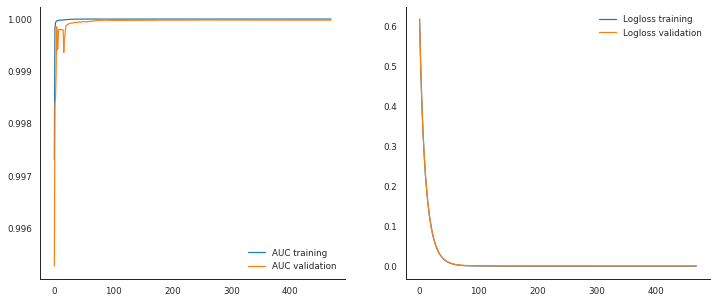

In [ ]:
# get evaluation results
evals_results_xgb_lr = clf_xgb_lr.evals_result()

# get loss and AUC by epoch
auc_train_xgb_lr, auc_val_xgb_lr, loss_train_xgb_lr, loss_val_xgb_lr, i_xgb_lr = get_xgboost_evals_results(evals_results_xgb_lr)

# plot loss and AUC
plot_model_performance(i_xgb_lr, auc_train_xgb_lr, auc_val_xgb_lr, loss_train_xgb_lr, loss_val_xgb_lr)

In [ ]:
# XGBClassifier predictions
preds_xgb_lr = clf_xgb_lr.predict(X_test)
preds_xgb_lr_train = clf_xgb_lr.predict(X_train)
preds_xgb_lr_val = clf_xgb_lr.predict(X_val)

In [ ]:
get_metrics(y_test, preds_xgb_lr)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  553541                  33
fraud (ground truth)                          51                2094

AUC on test set: 0.98808
FPR on test set: 0.00596
TPR on test set: 97.62238
FNR on test set: 2.37762
TNR on test set: 99.99404


In [ ]:
get_metrics(y_train, preds_xgb_lr_train, set_name="train")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  937637                   0
fraud (ground truth)                           0                5343

AUC on train set: 1.0
FPR on train set: 0.0
TPR on train set: 100.0
FNR on train set: 0.0
TNR on train set: 100.0


In [ ]:
get_metrics(y_val, preds_xgb_lr_val, set_name="validation")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  349054                  34
fraud (ground truth)                          19                2120

AUC on validation set: 0.99551
FPR on validation set: 0.00974
TPR on validation set: 99.11173
FNR on validation set: 0.88827
TNR on validation set: 99.99026


### Hyperparameter tuning conclusion

I have reduced the FPR from .006 to .005, while increasing the TPR from 97.48 to 97.62 and AUC from .987 to .988

Can I reduce the FPR a little bit more without having a negative impact on the TPR? To explore this, I will test different threshold and choose the one that gives us this combination of results.

### Try different thresholds

As I can see from the DataFrame with scores for each threshold, I find a high AUC for all of them, with the lowest value being at .984 for a threshold of .90

As I reduced the threshold, AUC, BER and G-mean scores increase, as well as the TPR. However, the FPR increase. As I do want to reduce the FPR without having a huge negative impact on the TPR, I will focus in these two metrics.

Considering the results for a threshold of .50:

* With a threshold of .70 I will reduce the TPR in .24%, while decreasing the FPR in 27.18%

* With a threshold of .80 I will reduce the TPR in .48%, while decreasing the FPR in 33.39%

In light of these results, **I dicided to use a threshold of .70**, as it helps to reduce the FPR without negatively impacting much on the TPR, as its increase doubles from a reduction of .24% at .70 to .48% at .80

*Note. A threshold of .75 gives us the same FPR than .80, so I did not considered it*

In [ ]:
THRESHOLDS = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

In [ ]:
thresholds_results = get_scores_thresholds(y_test, X_test, clf_xgb_lr, THRESHOLDS)
display(thresholds_results)

Working on result for threshold: 0.9
Working on result for threshold: 0.85
Working on result for threshold: 0.8
Working on result for threshold: 0.75
Working on result for threshold: 0.7
Working on result for threshold: 0.65
Working on result for threshold: 0.6
Working on result for threshold: 0.55
Working on result for threshold: 0.5
Working on result for threshold: 0.45
Working on result for threshold: 0.4
Working on result for threshold: 0.35
Working on result for threshold: 0.3
Working on result for threshold: 0.25
Working on result for threshold: 0.2
Working on result for threshold: 0.15
Working on result for threshold: 0.1


TP    FP        TN    FN       TPR      FPR       TNR      FNR  \
Threshold                                                                       
0.90       2079.0  12.0  553562.0  66.0  96.92308  0.00217  99.99783  3.07692   
0.85       2082.0  19.0  553555.0  63.0  97.06294  0.00343  99.99657  2.93706   
0.80       2084.0  22.0  553552.0  61.0  97.15618  0.00397  99.99603  2.84382   
0.75       2085.0  22.0  553552.0  60.0  97.20280  0.00397  99.99603  2.79720   
0.70       2089.0  24.0  553550.0  56.0  97.38928  0.00434  99.99566  2.61072   
0.65       2092.0  28.0  553546.0  53.0  97.52914  0.00506  99.99494  2.47086   
0.60       2092.0  30.0  553544.0  53.0  97.52914  0.00542  99.99458  2.47086   
0.55       2093.0  31.0  553543.0  52.0  97.57576  0.00560  99.99440  2.42424   
0.50       2094.0  33.0  553541.0  51.0  97.62238  0.00596  99.99404  2.37762   
0.45       2095.0  37.0  553537.0  50.0  97.66900  0.00668  99.99332  2.33100   
0.40       2096.0  41.0  553533.0  49.0  97.71562  0.00741  99.99259  2.28438   
0.35       2098.0  50.0  553524.0  47.0  97.80886  0.00903  99.99097  2.19114   
0.30       2101.0  52.0  553522.0  44.0  97.94872  0.00939  99.99061  2.05128   
0.25       2101.0  57.0  553517.0  44.0  97.94872  0.01030  99.98970  2.05128   
0.20       2106.0  61.0  553513.0  39.0  98.18182  0.01102  99.98898  1.81818   
0.15       2107.0  67.0  553507.0  38.0  98.22844  0.01210  99.98790  1.77156   
0.10       2108.0  77.0  553497.0  37.0  98.27506  0.01391  99.98609  1.72494   

                BER    G-mean  F1_micro      AUC  
Threshold                                         
0.90       0.015395  9.844845   0.99986  0.98460  
0.85       0.014702  9.851884   0.99985  0.98530  
0.80       0.014239  9.856588   0.99985  0.98576  
0.75       0.014006  9.858952   0.99985  0.98599  
0.70       0.013075  9.868387   0.99986  0.98692  
0.65       0.012380  9.875435   0.99985  0.98762  
0.60       0.012381  9.875417   0.99985  0.98762  
0.55       0.012149  9.877768   0.99985  0.98785  
0.50       0.011918  9.880109   0.99985  0.98808  
0.45       0.011688  9.882432   0.99984  0.98831  
0.40       0.011459  9.884755   0.99984  0.98854  
0.35       0.011001  9.889390   0.99983  0.98900  
0.30       0.010303  9.896440   0.99983  0.98970  
0.25       0.010308  9.896395   0.99982  0.98969  
0.20       0.009146  9.908128   0.99982  0.99085  
0.15       0.008918  9.910426   0.99981  0.99108  
0.10       0.008694  9.912688   0.99979  0.99131

In [ ]:
# chosen threshold
THRESHOLD =.7

# predict probabilities and set the label based on the chosen threshold
preds_xgb_lr_proba = np.ndarray.flatten((clf_xgb_lr.predict_proba(X_test)[:, 1] 
                                         > THRESHOLD)).astype("int32")

# print labels
display(preds_xgb_lr_proba)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
# get metrics for the test set
get_metrics(y_test, preds_xgb_lr_proba)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  553550                  24
fraud (ground truth)                          56                2089

AUC on test set: 0.98692
FPR on test set: 0.00434
TPR on test set: 97.38928
FNR on test set: 2.61072
TNR on test set: 99.99566


## Save model

In [ ]:
# # save in Jupyter Notebook
# clf_xgb.save_model(os.path.join(os.getcwd(), ".models/XGB_classifier.json"))

In [ ]:
# save in Colab
clf_xgb_lr.save_model(os.path.join(model_path_gd, "XGB_classifier"))

## Load model

In [ ]:
# clf_xgb = xgb.XGBClassifier()
# # load for Jupyter Notebook
# clf_xgb.load_model(os.path.join(os.getcwd(), ".models/XGB_classifier"))

In [ ]:
THRESHOLD = .7
clf_xgb = xgb.XGBClassifier()

# load for Colab
clf_xgb.load_model(os.path.join(model_path_gd, "XGB_classifier"))
clf_xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['auc', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0812324508558869,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=11,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=470, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0.58, ...)

In [ ]:
# compute auc score with loaded model
preds_proba_xgb = np.ndarray.flatten((clf_xgb.predict_proba(X_test)[:, 1] 
                                  > THRESHOLD)).astype("int32")

# get metrics for the test set
get_metrics(y_test, preds_proba_xgb)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  553550                  24
fraud (ground truth)                          56                2089

AUC on test set: 0.98692
FPR on test set: 0.00434
TPR on test set: 97.38928
FNR on test set: 2.61072
TNR on test set: 99.99566


## Feature importances

Now that I have built our models, let's explore feature importances using SHAP library. This library makes use of SHAP values (SHapley Additive exPlanations) which measures the contribution of each feature into model prediction. This librabry offers global interpretability, which is what I am going to focus on. However, you can also explore the local interpretability, being able to see the predictors contribution to each individual prediction.

There is a great post in Medium by Dr. Dataman (Chris Kuo) about SHAP values and how to interpret them for model explainability: 

* https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [ ]:
# use Tree Explainer for tree-based models
explainer_xgb = shap.TreeExplainer(clf_xgb_lr)

# extrain shap values from the model
shap_values_xgb = explainer_xgb.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


**PLOT EXPLANATION**

In the bar plot features are sorted in descending order of features importances.


**PREDICTORS INTERPRETABILITY**

From the summary plot of features importances I can see that **three predictors have the biggest contribution to the model**. First, the *amount of transactions each week per quarter (amt_week_quarter)*, followed by the *cumulative count of transactions per day (cumcount_trans_day)*, and finally by the *class of the previous transaction (lag_fraud)* (either fraud or non-fraud).

Next, I identify **two features with a lower but important contribution**. These two features are the *cumulative sum of amount per day (cumsum_amt_day)* and the *amount of the transaction (amt_log)*.

Interestingly, the *total seconds of the day (total_seconds_day)* and the *hour of the day (hour)* also contribute to the model, although to a lower extent.

**I was expecting hour of the day and total seconds of the day to have a bigger contribution that they actually have**. In the EDA analysis I found that most of the fraud transactions take place at night, that is during late (22 to 24 pm) and early hours of the day (0 to 4 am). Similarly, the same was hypothesized for month of the year, as the number of fraud transactions peaked during the Christmas season.

**Another thing that is surprising is that the categories "gas-transport" has a bigger importance that "shopping-net" and "grocery-pos", as higher number of fraud transactions are found for the later two categories**. It could be possible that the former categories could contribute to the model to distinguish well, in some way, between fraud and non-fraud transactions. I will explore this in the violin plot below.

In general, this seems to indicate that having good engineered features, which are able to combine and capture more variance in the data, is more important that simple features provided in the original raw data. Nevetheless, I should also noted that some of the engineered features that I have created do not have a significant contribution to model predictions. Hence, the process of feature engineering should be done carefully and testing the imporantance of the new features created.

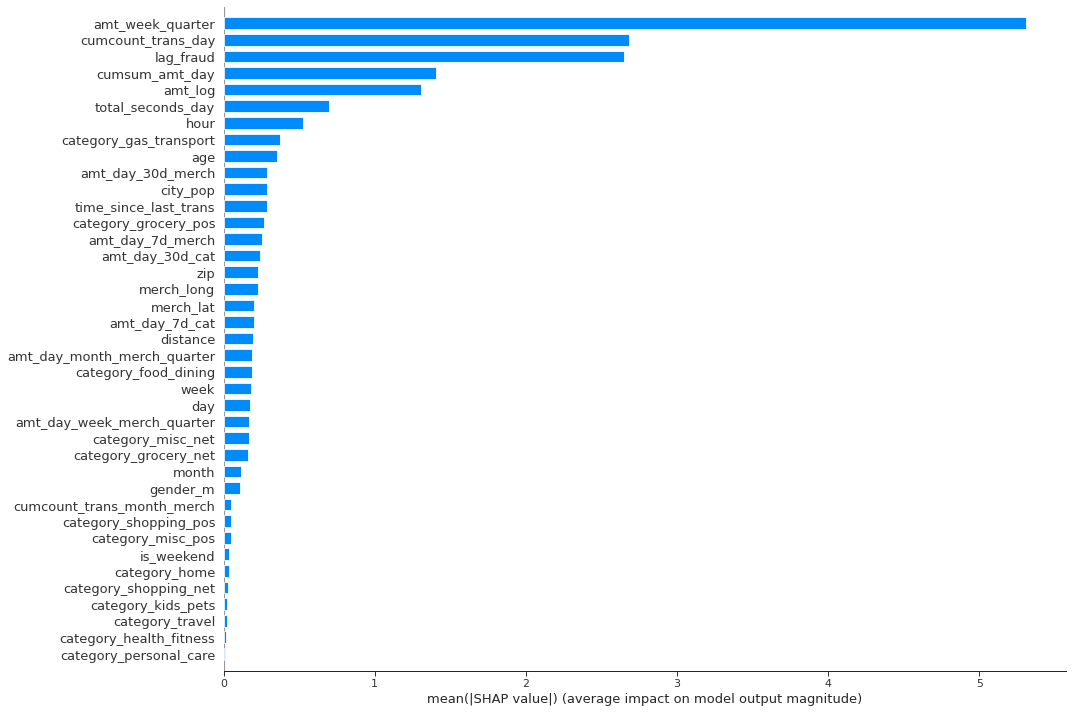

In [ ]:
# bar plot with features importances
shap.summary_plot(shap_values_xgb, X_test_df, plot_type="bar", 
                  max_display=len(X_test_df.columns), plot_size=(15, 10))

**PLOT EXPLANATION**

In the violin plot, I can see the positive and negative contribution of each feature to model predictions. 

* As in the bar plot, in the y-axis features are presented sorted in descending order of importance. 

* In the x-axis I have the model prediction, with positive values indicating pertenence to the positive class (fraud), and negative values to the negative class (non-fraud)

* In the color bar at the right side of the plot I have the feature value, with pink colors indicating a higher value, and blue color a lower one.

**PREDICTORS INTERPRETABILITY**

*Amount each week per quarter (amt_week_quarter)*, *class of the previous transaction (lag_fraud)* or *cumulative sum of amount per day (cumsum_amt_day)*, have a positive correlation with the output variable. That is, the higher the amount and the positive the previous transaction, the more likely the prediction would be positive (fraud transaction)

As expected, *higher hour of the day (hour)* is generally associated with a positive prediction. While this association is not very clear for *total seconds of the day (total_seconds_day)*, which does not seem to distinguid very well between fraud and non-fraud transactions.

I can also see that transaction category *gas-transport*, *food-dining*, *grocery-pos* and *grocery-net* help to distinguish between fraud and non-fraud transactions quite well. Other categories such as *misc-net*, *shopping-pos*, *shopping-net* and *travel* are surprinsingly negative associated with the predictions. This is specially surprinsing in the case of *shopping-net* and *misc-net* which have a high number of fraud transactions.

Finally, the *cumulation count of transactions per day (cumcount_trans_day)* and *time since last transaction* are negatively correlated with the output variable. I can see that lower values are associated with a positive output.

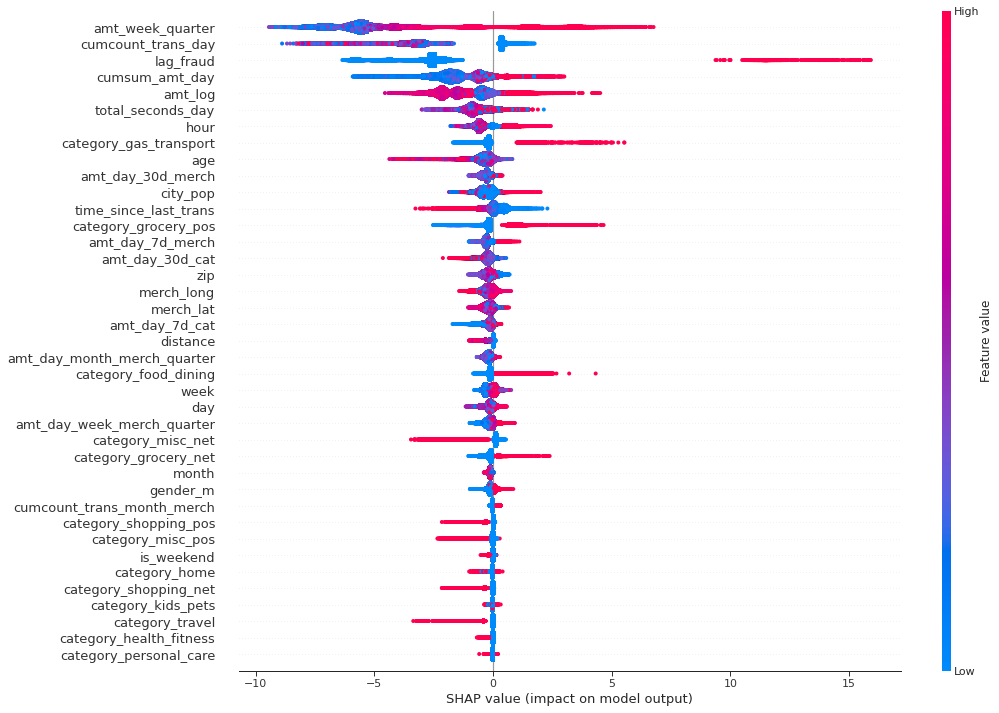

In [ ]:
# violin plot with features contribution to each class prediction
shap.summary_plot(shap_values_xgb, X_test_df, 
                  max_display=len(X_test_df.columns), plot_size=(15, 10))

In [ ]:
# shap.initjs()
# shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[:1000,:], X_test_df.iloc[:1000,:])

## LightGBM Classifier - Simple model

Due to the leaf-wise tree growth of the model, LightGBM has a higher tendency to overfit compared to XGBoost that uses a depth-wise tree growth.

In [ ]:
clf_lgbm_base = LGBMClassifier(objective="binary",
                               n_estimators=100,
                               bagging_fraction=0.8, # subsample (XGB)
                               feature_fraction=0.8, # colsample_bytree (XGB)
                               num_leaves=31,
                               subsample_freq=1, # to enable bagging
                               scale_pos_weight=scale_pos_weight,
                               device="cpu",
                               random_state=seed_number,
                               snapshot_freq=5,
                               output_model=os.path.join(model_path_gd, "LightGBM_classifier"))

clf_lgbm_base.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  eval_metric=["binary_logloss", "auc"])

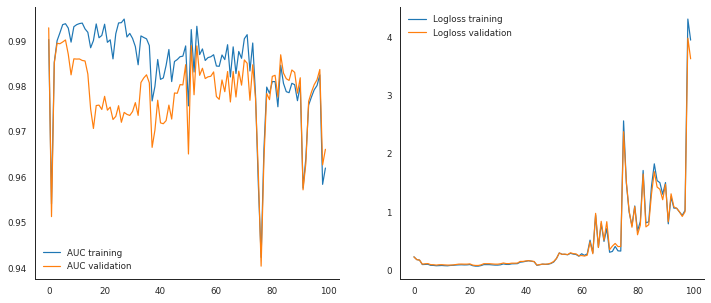

In [ ]:
# extract evaluation results
evals_results_lgbm_base = clf_lgbm_base.evals_result_

# get loss and AUC by epochs
auc_train_lgbm, auc_val_lgbm, loss_train_lgbm, loss_val_lgbm, i_list_lgbm = get_lgbm_evals_results(evals_results_lgbm_base)

# plot loss and AUC
plot_model_performance(i_list_lgbm, auc_train_lgbm, auc_val_lgbm, loss_train_lgbm, loss_val_lgbm)

In [ ]:
# LGBMClassifier predictions
preds_lgbm_base = clf_lgbm_base.predict(X_test)
preds_lgbm_base_train = clf_lgbm_base.predict(X_train)
preds_lgbm_base_val = clf_lgbm_base.predict(X_val)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


In [ ]:
# get metrics for the test set
get_metrics(y_test, preds_lgbm_base)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  485724               67850
fraud (ground truth)                         101                2044

AUC on test set: 0.91517
FPR on test set: 12.25672
TPR on test set: 95.29138
FNR on test set: 4.70862
TNR on test set: 87.74328


In [ ]:
# get metrics for the train set
get_metrics(y_train, preds_lgbm_base_train, set_name="train")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  828806              108831
fraud (ground truth)                         148                5195

AUC on train set: 0.92812
FPR on train set: 11.60694
TPR on train set: 97.23002
FNR on train set: 2.76998
TNR on train set: 88.39306


In [ ]:
# get metrics for the val set
get_metrics(y_val, preds_lgbm_base_val, set_name="validation")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  311757               37331
fraud (ground truth)                          69                2070

AUC on validation set: 0.9304
FPR on validation set: 10.69387
TPR on validation set: 96.77419
FNR on validation set: 3.22581
TNR on validation set: 89.30613


## Hyperparameter tuning

As I have had problems using the alias "max_leaves" for "num_leaves", as "num_leaves" was overiding "max_leaves", I will avoid aliases and use the names given in the LGBM documentation. I wanted to use the same names as for XGBoost, but to avoid possible mistakes, I will use the default ones.

* num_leaves for max_leaves
* bagging_fraction for subsample
* feature_fraction for colsample_bytree
* min_sum_hessian_in_leaf for min_child_weight
* min_gain_to_split for gamma
* l2_lambda for lambda_reg

**Note:** As I have encounter a lot of split with no further positive gains, I will introduce early stopping to reduce training times. I will set the number of stopping rounds to 5.

"min_sum_hessian_in_leaf" and "min_gain_to_split" does not contribute much to model performance during hyperaparameter tuning, so I will discard it completely.

In [ ]:
n_stopping_rounds = 5
early_stopping_callback = lightgbm.early_stopping(stopping_rounds=n_stopping_rounds) # LightGBM early stopping callback

### Booster parameters

In XGBoost I used the default "non-limit" number of max leaves. However, as in LGBM the default number of 31 and there is not value to set it to "non-limit", I will also tune it. As recommeded, I will set the maximum number of leaves to "max_depth"^2

Finally, I will tune the same parameters tuned for XGBoost in this step.

In [ ]:
def objective_lgbm(trial, X_train, y_train, X_val, y_val, device):

    """
    Objective function to be used for hyperparameter tuning
    for XGBoost with Optuna.

    Input:
        trial (int): number of predefined trials during hyperparameter
                     tuning.
        X_train
        y_train
        X_val
        y_val
    Output:
        scores: f1 scores.
    """
      
    lgbm_param_grid = {"n_estimators": trial.suggest_int("n_estimators", 10, 500, 10),
                       "max_depth": trial.suggest_int("max_depth", 3, 12),
                       "num_leaves": trial.suggest_int("num_leaves", 2, 144, step=8), # max_leaves (XGB). Set the maximum of num_leaves to maximum of max_depth^2-1
                       "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 0.9, step=0.1), # colsample_bytree (XGB)
                       "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.9, step=0.1)} # subsample (XGB)

    # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "binary_logloss", "valid_1") # Optuna prunning callback

    if device == "cpu":
      pass
    elif device == "gpu":
      train_device = device

    model = LGBMClassifier(objective="binary",
                           scale_pos_weight=scale_pos_weight, # class_weight is recommended to be only used for multiclass classification problems
                           bagging_freq=1, # to enable bagging
                           random_state=seed_number,
                           device=device,
                           **lgbm_param_grid)
    
    model.fit(X_train,
              y_train,
              eval_metric=["binary_logloss", "auc"],
              eval_set=[(X_train, y_train), (X_val, y_val)],
              callbacks=[early_stopping_callback])

    return np.mean(model.evals_result_["valid_1"]["binary_logloss"])

In [ ]:
lgbm_hp_tree_params, lgbm_hp_tree_score = tune_optuna(model="lgbm", device="gpu", study_name="LightGBM_tree_params")

[I 2023-01-05 17:28:38,957] A new study created in memory with name: LightGBM_tree_params
The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDI

[I 2023-01-05 17:28:45,295] Trial 0 finished with value: 0.1696178929710798 and parameters: {'n_estimators': 190, 'max_depth': 12, 'num_leaves': 106, 'feature_fraction': 0.7, 'bagging_fraction': 0.5}. Best is trial 0 with value: 0.1696178929710798.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.125022	training's auc: 0.983633	valid_1's binary_logloss: 0.129183	valid_1's auc: 0.975161


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDI

[I 2023-01-05 17:28:50,658] Trial 1 finished with value: 0.347682409522438 and parameters: {'n_estimators': 80, 'max_depth': 3, 'num_leaves': 122, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}. Best is trial 0 with value: 0.1696178929710798.


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.264597	training's auc: 0.866191	valid_1's binary_logloss: 0.26484	valid_1's auc: 0.858219
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.031509 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree

[I 2023-01-05 17:28:55,616] Trial 2 finished with value: 0.2051237132926138 and parameters: {'n_estimators': 20, 'max_depth': 12, 'num_leaves': 114, 'feature_fraction': 0.6, 'bagging_fraction': 0.5}. Best is trial 0 with value: 0.1696178929710798.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.253956	training's auc: 0.978217	valid_1's binary_logloss: 0.259892	valid_1's auc: 0.962899
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.031433 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree

[I 2023-01-05 17:28:59,958] Trial 3 finished with value: 0.19097961363689006 and parameters: {'n_estimators': 100, 'max_depth': 6, 'num_leaves': 74, 'feature_fraction': 0.7, 'bagging_fraction': 0.6}. Best is trial 0 with value: 0.1696178929710798.
The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDI

[I 2023-01-05 17:29:04,061] Trial 4 finished with value: 0.5443039588361956 and parameters: {'n_estimators': 310, 'max_depth': 4, 'num_leaves': 42, 'feature_fraction': 0.6, 'bagging_fraction': 0.7}. Best is trial 0 with value: 0.1696178929710798.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.591293	training's auc: 0.972859	valid_1's binary_logloss: 0.578911	valid_1's auc: 0.975961


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDI

[I 2023-01-05 17:29:08,614] Trial 5 finished with value: 0.26344646164353375 and parameters: {'n_estimators': 400, 'max_depth': 4, 'num_leaves': 74, 'feature_fraction': 0.7, 'bagging_fraction': 0.5}. Best is trial 0 with value: 0.1696178929710798.
The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDI

[I 2023-01-05 17:29:12,620] Trial 6 finished with value: 0.2335401766621369 and parameters: {'n_estimators': 310, 'max_depth': 4, 'num_leaves': 10, 'feature_fraction': 0.9, 'bagging_fraction': 0.9}. Best is trial 0 with value: 0.1696178929710798.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.337573	training's auc: 0.979897	valid_1's binary_logloss: 0.338204	valid_1's auc: 0.984568
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.031599 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree

[I 2023-01-05 17:29:17,373] Trial 7 finished with value: 0.2510997749115883 and parameters: {'n_estimators': 410, 'max_depth': 6, 'num_leaves': 10, 'feature_fraction': 0.8, 'bagging_fraction': 0.7}. Best is trial 0 with value: 0.1696178929710798.


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.238498	training's auc: 0.993989	valid_1's binary_logloss: 0.256409	valid_1's auc: 0.992125
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.034644 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree

[I 2023-01-05 17:29:21,222] Trial 8 finished with value: 1.4313004251165273 and parameters: {'n_estimators': 70, 'max_depth': 7, 'num_leaves': 2, 'feature_fraction': 0.9, 'bagging_fraction': 0.6}. Best is trial 0 with value: 0.1696178929710798.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.57893	training's auc: 0.946002	valid_1's binary_logloss: 0.602436	valid_1's auc: 0.953724
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.031980 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree

[I 2023-01-05 17:29:25,876] Trial 9 finished with value: 0.17518275938367642 and parameters: {'n_estimators': 340, 'max_depth': 6, 'num_leaves': 74, 'feature_fraction': 0.7, 'bagging_fraction': 0.5}. Best is trial 0 with value: 0.1696178929710798.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.207273	training's auc: 0.990617	valid_1's binary_logloss: 0.208512	valid_1's auc: 0.991685
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.032068 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree

[I 2023-01-05 17:29:30,387] Trial 10 finished with value: 0.10784333486911994 and parameters: {'n_estimators': 490, 'max_depth': 10, 'num_leaves': 130, 'feature_fraction': 0.9, 'bagging_fraction': 0.7}. Best is trial 10 with value: 0.10784333486911994.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.153491	training's auc: 0.990405	valid_1's binary_logloss: 0.158534	valid_1's auc: 0.970215
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.031714 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree

[I 2023-01-05 17:29:34,418] Trial 11 finished with value: 0.6638286507182399 and parameters: {'n_estimators': 470, 'max_depth': 3, 'num_leaves': 26, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 10 with value: 0.10784333486911994.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.675234	training's auc: 0.95383	valid_1's binary_logloss: 0.636978	valid_1's auc: 0.957827
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.031990 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree

[I 2023-01-05 17:29:39,901] Trial 12 finished with value: 0.7433727741941145 and parameters: {'n_estimators': 200, 'max_depth': 5, 'num_leaves': 114, 'feature_fraction': 0.6, 'bagging_fraction': 0.6}. Best is trial 10 with value: 0.10784333486911994.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.481092	training's auc: 0.982156	valid_1's binary_logloss: 0.476706	valid_1's auc: 0.985589
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.034071 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree

[I 2023-01-05 17:29:44,153] Trial 13 finished with value: 0.346793749176153 and parameters: {'n_estimators': 280, 'max_depth': 4, 'num_leaves': 114, 'feature_fraction': 0.5, 'bagging_fraction': 0.9}. Best is trial 10 with value: 0.10784333486911994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.613504	training's auc: 0.972535	valid_1's binary_logloss: 0.59381	valid_1's auc: 0.975982


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDI

[I 2023-01-05 17:29:49,056] Trial 14 finished with value: 1.1331695782895366 and parameters: {'n_estimators': 390, 'max_depth': 4, 'num_leaves': 2, 'feature_fraction': 0.9, 'bagging_fraction': 0.8}. Best is trial 10 with value: 0.10784333486911994.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.578961	training's auc: 0.946002	valid_1's binary_logloss: 0.602463	valid_1's auc: 0.953724
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.031584 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree

[I 2023-01-05 17:29:53,683] Trial 15 finished with value: 0.810623511171577 and parameters: {'n_estimators': 370, 'max_depth': 10, 'num_leaves': 10, 'feature_fraction': 0.6, 'bagging_fraction': 0.5}. Best is trial 10 with value: 0.10784333486911994.


[LightGBM] [Info] 25 dense feature groups (12.58 MB) transferred to GPU in 0.019448 secs. 1 sparse feature groups
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.471762	training's auc: 0.246836	valid_1's binary_logloss: 0.457752	valid_1's auc: 0.233929


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDI

[I 2023-01-05 17:29:58,077] Trial 16 finished with value: 0.3418213112935732 and parameters: {'n_estimators': 440, 'max_depth': 9, 'num_leaves': 42, 'feature_fraction': 0.5, 'bagging_fraction': 0.6}. Best is trial 10 with value: 0.10784333486911994.


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.214906	training's auc: 0.771693	valid_1's binary_logloss: 0.203723	valid_1's auc: 0.791309
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.031542 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree

[I 2023-01-05 17:30:02,521] Trial 17 finished with value: 0.1397704823498532 and parameters: {'n_estimators': 170, 'max_depth': 10, 'num_leaves': 90, 'feature_fraction': 0.9, 'bagging_fraction': 0.7}. Best is trial 10 with value: 0.10784333486911994.


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0852431	training's auc: 0.902353	valid_1's binary_logloss: 0.0845067	valid_1's auc: 0.89849
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.032117 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree

[I 2023-01-05 17:30:06,748] Trial 18 finished with value: 0.16123874193941026 and parameters: {'n_estimators': 60, 'max_depth': 10, 'num_leaves': 106, 'feature_fraction': 0.7, 'bagging_fraction': 0.8}. Best is trial 10 with value: 0.10784333486911994.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.156156	training's auc: 0.991546	valid_1's binary_logloss: 0.15989	valid_1's auc: 0.975187
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


The distribution is specified by [2, 144] and step=8, but the range is not divisible by `step`. It will be replaced by [2, 138].


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (25.18 MB) transferred to GPU in 0.032063 secs. 1 sparse feature groups
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree

[I 2023-01-05 17:30:11,376] Trial 19 finished with value: 0.2899058500840626 and parameters: {'n_estimators': 250, 'max_depth': 8, 'num_leaves': 58, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}. Best is trial 10 with value: 0.10784333486911994.


In [ ]:
for keys, values in lgbm_hp_tree_params.items():
    lgbm_hp_tree_params = values

print(lgbm_hp_tree_params)
print(lgbm_hp_tree_score)

{'n_estimators': 490, 'max_depth': 10, 'num_leaves': 130, 'feature_fraction': 0.9, 'bagging_fraction': 0.7}
{<built-in function bin>: 0.10784333486911994}


In [ ]:
# lgbm_hp_tree_params = {'n_estimators': 490, 
#                        'max_depth': 10, 
#                        'num_leaves': 130, 
#                        'feature_fraction': 0.9, 
#                        'bagging_fraction': 0.7}

In [ ]:
clf_lgbm_hp_tree = LGBMClassifier(objective="binary",
                                  scale_pos_weight=scale_pos_weight,
                                  bagging_freq=1,
                                  device="gpu",
                                  random_state=seed_number,
                                  snapshot_freq=5,
                                  output_model=os.path.join(model_path_gd, "LightGBM_classifier")).set_params(**lgbm_hp_tree_params)

clf_lgbm_hp_tree.fit(X_train, y_train,
                     eval_set=[(X_train, y_train), (X_val, y_val)],
                     eval_metric=["binary_logloss", "auc"],
                     callbacks=[early_stopping_callback])

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 942980, number of used features: 39
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDI

LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, device='gpu',
               feature_fraction=0.9, max_depth=10, n_estimators=490,
               num_leaves=130, objective='binary',
               output_model='drive/MyDrive/GITHUB/data_science_projects/fraud_detection/.models/LightGBM_classifier',
               random_state=42, scale_pos_weight=175.48886393411942,
               snapshot_freq=5)

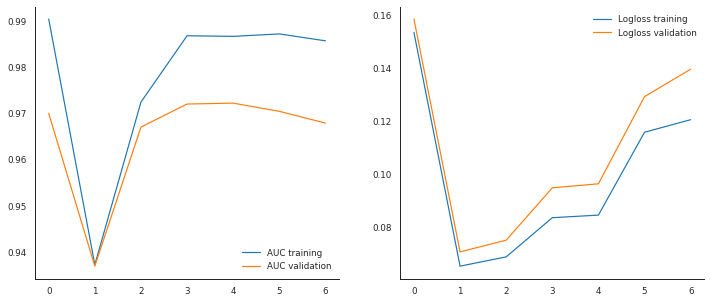

In [ ]:
# get evaluation results
evals_results_lgbm_hp_tree = clf_lgbm_hp_tree.evals_result_

# get loss and AUC by epoch
auc_train_lgbm_hp_tree, auc_val_lgbm_hp_tree, loss_train_lgbm_hp_tree, loss_val_lgbm_hp_tree, i_lgbm_hp_tree = get_lgbm_evals_results(evals_results_lgbm_hp_tree)

# plot loss and AUC
plot_model_performance(i_lgbm_hp_tree, auc_train_lgbm_hp_tree, auc_val_lgbm_hp_tree, loss_train_lgbm_hp_tree, loss_val_lgbm_hp_tree)

In [ ]:
# LGBMClassifier predictions
preds_lgbm_hp_tree = clf_lgbm_hp_tree.predict(X_test)
preds_lgbm_hp_tree_train = clf_lgbm_hp_tree.predict(X_train)
preds_lgbm_hp_tree_val = clf_lgbm_hp_tree.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will b

In [ ]:
get_metrics(y_test, preds_lgbm_hp_tree)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  550401                3173
fraud (ground truth)                         269                1876

AUC on test set: 0.93443
FPR on test set: 0.57318
TPR on test set: 87.45921
FNR on test set: 12.54079
TNR on test set: 99.42682


In [ ]:
get_metrics(y_train, preds_lgbm_hp_tree_train, set_name="train")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  932361                5276
fraud (ground truth)                         479                4864

AUC on train set: 0.95236
FPR on train set: 0.56269
TPR on train set: 91.035
FNR on train set: 8.965
TNR on train set: 99.43731


In [ ]:
get_metrics(y_val, preds_lgbm_hp_tree_val, set_name="validation")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  346974                2114
fraud (ground truth)                         234                1905

AUC on validation set: 0.94227
FPR on validation set: 0.60558
TPR on validation set: 89.06031
FNR on validation set: 10.93969
TNR on validation set: 99.39442


### Regularization

In [ ]:
def objective_lgbm(trial, X_train, y_train, X_val, y_val, device):

    """
    Objective function to be used for hyperparameter tuning
    for XGBoost with Optuna.

    Input:
        trial (int): number of predefined trials during hyperparameter
                     tuning.
        X_train
        y_train
        X_val
        y_val
    Output:
        scores: f1 scores.
    """
      
    lgbm_param_grid = {"n_estimators": lgbm_hp_tree_params["n_estimators"],
                       "max_depth": lgbm_hp_tree_params["max_depth"],
                       "num_leaves": lgbm_hp_tree_params["num_leaves"], # max_leaves (XGB)
                       "feature_fraction": lgbm_hp_tree_params["feature_fraction"], # colsample_bytree (XGB)
                       "bagging_fraction": lgbm_hp_tree_params["bagging_fraction"], # subsample (XGB)
                       "lambda_l2": trial.suggest_float("lambda_l2", 0, 10, step=0.001)} # reg_lambda (XGB)

    # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "binary_logloss", "valid_1") # Optuna prunning callback

    if device == "cpu":
      pass
    elif device == "gpu":
      train_device = device

    model = LGBMClassifier(objective="binary",
                           scale_pos_weight=scale_pos_weight, # class_weight is recommended to be only used for multiclass classification problems
                           bagging_freq=1,
                           random_state=seed_number,
                           device=device,
                           **lgbm_param_grid)
    
    model.fit(X_train,
              y_train,
              eval_metric=["binary_logloss", "auc"],
              eval_set=[(X_train, y_train), (X_val, y_val)],
              callbacks=[early_stopping_callback])

    return np.mean(model.evals_result_["valid_1"]["binary_logloss"])

In [ ]:
lgbm_hp_L2_reg_params, lgbm_hp_L2_reg_score = tune_optuna(model="lgbm", device="gpu", study_name="LightGBM_L2_reg_params")

[I 2023-01-05 17:34:00,372] A new study created in memory with name: LightGBM_L2_reg_params


[LightGBM] [Warning] lambda_l2 is set=3.745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.745
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.745
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Inf

[I 2023-01-05 17:34:08,919] Trial 0 finished with value: 0.09564749419649853 and parameters: {'lambda_l2': 3.745}. Best is trial 0 with value: 0.09564749419649853.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.271599	training's auc: 0.993494	valid_1's binary_logloss: 0.284497	valid_1's auc: 0.992388
[LightGBM] [Warning] lambda_l2 is set=9.508000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.508000000000001
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.508000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.508000000000001
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_fre

[I 2023-01-05 17:34:15,465] Trial 1 finished with value: 0.1149542725308703 and parameters: {'lambda_l2': 9.508000000000001}. Best is trial 0 with value: 0.09564749419649853.


[LightGBM] [Warning] lambda_l2 is set=7.32, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.32
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.32, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.32
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] T

[I 2023-01-05 17:34:20,417] Trial 2 finished with value: 0.10214190453066499 and parameters: {'lambda_l2': 7.32}. Best is trial 0 with value: 0.09564749419649853.


[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Inf

[I 2023-01-05 17:34:25,380] Trial 3 finished with value: 0.08236954113930565 and parameters: {'lambda_l2': 5.987}. Best is trial 3 with value: 0.08236954113930565.


[LightGBM] [Warning] lambda_l2 is set=1.56, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.56
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.56, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.56
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Info] T

[I 2023-01-05 17:34:29,951] Trial 4 finished with value: 0.10024260369102171 and parameters: {'lambda_l2': 1.56}. Best is trial 3 with value: 0.08236954113930565.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.210211	training's auc: 0.994573	valid_1's binary_logloss: 0.218778	valid_1's auc: 0.993405
[LightGBM] [Warning] lambda_l2 is set=1.56, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.56
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.56, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.56
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7

[I 2023-01-05 17:34:34,577] Trial 5 finished with value: 0.10024869245662833 and parameters: {'lambda_l2': 1.56}. Best is trial 3 with value: 0.08236954113930565.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.210211	training's auc: 0.994572	valid_1's binary_logloss: 0.218779	valid_1's auc: 0.993403
[LightGBM] [Warning] lambda_l2 is set=0.58, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.58
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.58, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.58
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7

[I 2023-01-05 17:34:39,098] Trial 6 finished with value: 0.10534642816325107 and parameters: {'lambda_l2': 0.58}. Best is trial 3 with value: 0.08236954113930565.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.214218	training's auc: 0.994271	valid_1's binary_logloss: 0.215013	valid_1's auc: 0.990471
[LightGBM] [Warning] lambda_l2 is set=8.662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.662
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.662
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set

[I 2023-01-05 17:34:44,051] Trial 7 finished with value: 0.1045467305924767 and parameters: {'lambda_l2': 8.662}. Best is trial 3 with value: 0.08236954113930565.


[LightGBM] [Warning] lambda_l2 is set=6.011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.011
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.011
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Inf

[I 2023-01-05 17:34:48,982] Trial 8 finished with value: 0.0825681889059554 and parameters: {'lambda_l2': 6.011}. Best is trial 3 with value: 0.08236954113930565.


[LightGBM] [Warning] lambda_l2 is set=7.081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Inf

[I 2023-01-05 17:34:53,906] Trial 9 finished with value: 0.10310877206741387 and parameters: {'lambda_l2': 7.081}. Best is trial 3 with value: 0.08236954113930565.


[LightGBM] [Warning] lambda_l2 is set=0.20500000000000002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20500000000000002
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.20500000000000002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20500000000000002
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of po

[I 2023-01-05 17:34:58,457] Trial 10 finished with value: 0.11551109809959344 and parameters: {'lambda_l2': 0.20500000000000002}. Best is trial 3 with value: 0.08236954113930565.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.175627	training's auc: 0.993567	valid_1's binary_logloss: 0.182834	valid_1's auc: 0.982222
[LightGBM] [Warning] lambda_l2 is set=9.700000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.700000000000001
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.700000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.700000000000001
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_fre

[I 2023-01-05 17:35:03,344] Trial 11 finished with value: 0.11242438279880995 and parameters: {'lambda_l2': 9.700000000000001}. Best is trial 3 with value: 0.08236954113930565.


[LightGBM] [Warning] lambda_l2 is set=8.325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.325
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.325
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Inf

[I 2023-01-05 17:35:09,357] Trial 12 finished with value: 0.10162954664305406 and parameters: {'lambda_l2': 8.325}. Best is trial 3 with value: 0.08236954113930565.


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0367289	training's auc: 0.928488	valid_1's binary_logloss: 0.0391722	valid_1's auc: 0.923937
[LightGBM] [Warning] lambda_l2 is set=2.123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.123
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=2.123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.123
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is s

[I 2023-01-05 17:35:13,998] Trial 13 finished with value: 0.11283180933305385 and parameters: {'lambda_l2': 2.123}. Best is trial 3 with value: 0.08236954113930565.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.223416	training's auc: 0.994419	valid_1's binary_logloss: 0.232921	valid_1's auc: 0.993277
[LightGBM] [Warning] lambda_l2 is set=1.818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.818
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.818
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set

[I 2023-01-05 17:35:18,801] Trial 14 finished with value: 0.11962595747324485 and parameters: {'lambda_l2': 1.818}. Best is trial 3 with value: 0.08236954113930565.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.222621	training's auc: 0.994416	valid_1's binary_logloss: 0.232437	valid_1's auc: 0.993224
[LightGBM] [Warning] lambda_l2 is set=1.834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.834
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.834
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set

[I 2023-01-05 17:35:23,438] Trial 15 finished with value: 0.11543450211562645 and parameters: {'lambda_l2': 1.834}. Best is trial 3 with value: 0.08236954113930565.


[LightGBM] [Warning] lambda_l2 is set=3.0420000000000003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0420000000000003
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.0420000000000003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0420000000000003
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positi

[I 2023-01-05 17:35:28,049] Trial 16 finished with value: 0.09199339545939234 and parameters: {'lambda_l2': 3.0420000000000003}. Best is trial 3 with value: 0.08236954113930565.


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.272658	training's auc: 0.994137	valid_1's binary_logloss: 0.284444	valid_1's auc: 0.993106
[LightGBM] [Warning] lambda_l2 is set=5.248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.248
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.248
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set

[I 2023-01-05 17:35:32,640] Trial 17 finished with value: 0.09085130684748331 and parameters: {'lambda_l2': 5.248}. Best is trial 3 with value: 0.08236954113930565.


[LightGBM] [Warning] lambda_l2 is set=4.319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.319
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.319
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Inf

[I 2023-01-05 17:35:37,257] Trial 18 finished with value: 0.09497534756775063 and parameters: {'lambda_l2': 4.319}. Best is trial 3 with value: 0.08236954113930565.


[LightGBM] [Warning] lambda_l2 is set=2.912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.912
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=2.912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.912
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Inf

[I 2023-01-05 17:35:41,864] Trial 19 finished with value: 0.14295569013487672 and parameters: {'lambda_l2': 2.912}. Best is trial 3 with value: 0.08236954113930565.


In [ ]:
for keys, values in lgbm_hp_L2_reg_params.items():
    lgbm_hp_L2_params = values

print(lgbm_hp_L2_params)
print(lgbm_hp_L2_reg_score)

{'lambda_l2': 5.987}
{<built-in function bin>: 0.08236954113930565}


In [ ]:
lgbm_hp_tree_reg_L2_params = lgbm_hp_tree_params.copy()
lgbm_hp_tree_reg_L2_params.update(lgbm_hp_L2_params)
lgbm_hp_tree_reg_L2_params

{'n_estimators': 490,
 'max_depth': 10,
 'num_leaves': 130,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.7,
 'lambda_l2': 5.987}

In [ ]:
# lgbm_hp_tree_reg_L2_params = {'n_estimators': 490,
#                               'max_depth': 10,
#                               'num_leaves': 130,
#                               'feature_fraction': 0.9,
#                               'bagging_fraction': 0.7,
#                               'lambda_l2': 5.987}

In [ ]:
clf_lgbm_hp_L2 = LGBMClassifier(objective="binary",
                                scale_pos_weight=scale_pos_weight,
                                bagging_freq=1,
                                device="gpu",
                                random_state=seed_number,
                                snapshot_freq=5,
                                output_model=os.path.join(model_path_gd, "LightGBM_classifier")).set_params(**lgbm_hp_tree_reg_L2_params)

clf_lgbm_hp_L2.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric=["binary_logloss", "auc"],
                   callbacks=[early_stopping_callback])

[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [Inf

LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, device='gpu',
               feature_fraction=0.9, lambda_l2=5.987, max_depth=10,
               n_estimators=490, num_leaves=130, objective='binary',
               output_model='drive/MyDrive/GITHUB/data_science_projects/fraud_detection/.models/LightGBM_classifier',
               random_state=42, scale_pos_weight=175.48886393411942,
               snapshot_freq=5)

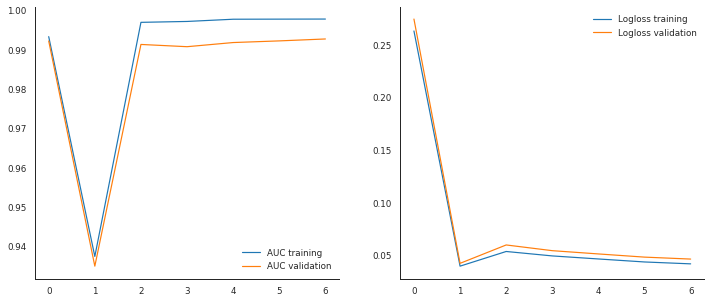

In [ ]:
# get evaluation results
evals_results_lgbm_hp_L2 = clf_lgbm_hp_L2.evals_result_

# get loss and AUC by epoch
auc_train_lgbm_hp_L2, auc_val_lgbm_hp_L2, loss_train_lgbm_hp_L2, loss_val_lgbm_hp_L2, i_lgbm_hp_L2 = get_lgbm_evals_results(evals_results_lgbm_hp_L2)

# plot loss and AUC
plot_model_performance(i_lgbm_hp_L2, auc_train_lgbm_hp_L2, auc_val_lgbm_hp_L2, loss_train_lgbm_hp_L2, loss_val_lgbm_hp_L2)

In [ ]:
# LGBMClassifier predictions
preds_lgbm_hp_L2 = clf_lgbm_hp_L2.predict(X_test)
preds_lgbm_hp_L2_train = clf_lgbm_hp_L2.predict(X_train)
preds_lgbm_hp_L2_val = clf_lgbm_hp_L2.predict(X_val)

[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current v

In [ ]:
get_metrics(y_test, preds_lgbm_hp_L2)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  550093                3481
fraud (ground truth)                         261                1884

AUC on test set: 0.93602
FPR on test set: 0.62882
TPR on test set: 87.83217
FNR on test set: 12.16783
TNR on test set: 99.37118


In [ ]:
get_metrics(y_train, preds_lgbm_hp_L2_train, set_name="train")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  931124                6513
fraud (ground truth)                         398                4945

AUC on train set: 0.95928
FPR on train set: 0.69462
TPR on train set: 92.551
FNR on train set: 7.449
TNR on train set: 99.30538


In [ ]:
get_metrics(y_val, preds_lgbm_hp_L2_val, set_name="validation")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  346377                2711
fraud (ground truth)                         186                1953

AUC on validation set: 0.95264
FPR on validation set: 0.7766
TPR on validation set: 91.30435
FNR on validation set: 8.69565
TNR on validation set: 99.2234


### Learning rate

To tune the learning rate, I will use CPU instead of GPU, due to the following error: LightGBMError: Check failed: (best_split_info.right_count) > (0) at /content/LightGBM/src/treelearner/serial_tree_learner.cpp, line 700 .

This seems to be a problem only when GPU is used but not with CPU.

In [ ]:
def objective_lgbm(trial, X_train, y_train, X_val, y_val, device):

    """
    Objective function to be used for hyperparameter tuning
    for XGBoost with Optuna.

    Input:
        trial (int): number of predefined trials during hyperparameter
                     tuning.
        X_train
        y_train
        X_val
        y_val
    Output:
        scores: f1 scores.
    """
      
    lgbm_param_grid = {"n_estimators": lgbm_hp_tree_reg_L2_params["n_estimators"],
                       "max_depth": lgbm_hp_tree_reg_L2_params["max_depth"],
                       "num_leaves": lgbm_hp_tree_reg_L2_params["num_leaves"], # max_leaves (XGB)
                       "feature_fraction": lgbm_hp_tree_reg_L2_params["feature_fraction"], # colsample_bytree (XGB)
                       "bagging_fraction": lgbm_hp_tree_reg_L2_params["bagging_fraction"], # subsample (XGB)
                       "lambda_l2": lgbm_hp_tree_reg_L2_params["lambda_l2"], # reg_lambda (XGB)
                       "learning_rate": trial.suggest_float("learning_rate", .0001, 0.1, log=True)}

    # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "binary_logloss", "valid_1") # Optuna prunning callback

    if device == "cpu":
      pass
    elif device == "gpu":
      train_device = device

    model = LGBMClassifier(objective="binary",
                           scale_pos_weight=scale_pos_weight, # class_weight is recommended to be only used for multiclass classification problems
                           bagging_freq=1,
                           random_state=seed_number,
                           device=device,
                           **lgbm_param_grid)
    
    model.fit(X_train,
              y_train,
              eval_metric=["binary_logloss", "auc"],
              eval_set=[(X_train, y_train), (X_val, y_val)],
              callbacks=[early_stopping_callback])

    return np.mean(model.evals_result_["valid_1"]["binary_logloss"])

In [ ]:
lgbm_hp_lr_params, lgbm_hp_lr_score = tune_optuna(model="lgbm", device="cpu", study_name="LightGBM_lr_params")

[I 2023-01-05 17:38:56,317] A new study created in memory with name: LightGBM_lr_params


[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [War

[I 2023-01-05 17:39:04,929] Trial 0 finished with value: 0.030360100809144575 and parameters: {'learning_rate': 0.0013292918943162175}. Best is trial 0 with value: 0.030360100809144575.


[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [War

[I 2023-01-05 17:39:10,239] Trial 1 finished with value: 0.04693752852539039 and parameters: {'learning_rate': 0.07114476009343425}. Best is trial 0 with value: 0.030360100809144575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0335812	training's auc: 0.999272	valid_1's binary_logloss: 0.0366993	valid_1's auc: 0.99902
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-01-05 17:39:35,694] Trial 2 finished with value: 0.012134279068447726 and parameters: {'learning_rate': 0.015702970884055395}. Best is trial 2 with value: 0.012134279068447726.


[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [War

[I 2023-01-05 17:39:43,717] Trial 3 finished with value: 0.023057403971450598 and parameters: {'learning_rate': 0.006251373574521752}. Best is trial 2 with value: 0.012134279068447726.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0194555	training's auc: 0.999764	valid_1's binary_logloss: 0.0206007	valid_1's auc: 0.999492
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

[I 2023-01-05 17:39:51,624] Trial 4 finished with value: 0.034785584770557695 and parameters: {'learning_rate': 0.00029380279387035364}. Best is trial 2 with value: 0.012134279068447726.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0319491	training's auc: 0.999681	valid_1's binary_logloss: 0.033915	valid_1's auc: 0.999585
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignore

[I 2023-01-05 17:39:59,705] Trial 5 finished with value: 0.03478590262422013 and parameters: {'learning_rate': 0.00029375384576328325}. Best is trial 2 with value: 0.012134279068447726.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0319495	training's auc: 0.999681	valid_1's binary_logloss: 0.0339155	valid_1's auc: 0.999585
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

[I 2023-01-05 17:40:07,728] Trial 6 finished with value: 0.03581783338472458 and parameters: {'learning_rate': 0.00014936568554617635}. Best is trial 2 with value: 0.012134279068447726.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0332427	training's auc: 0.999567	valid_1's binary_logloss: 0.0353033	valid_1's auc: 0.999515
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

[I 2023-01-05 17:41:29,578] Trial 7 finished with value: 0.006083004560206002 and parameters: {'learning_rate': 0.0396760507705299}. Best is trial 7 with value: 0.006083004560206002.


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.000543647	training's auc: 1	valid_1's binary_logloss: 0.0011293	valid_1's auc: 0.999978
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=

[I 2023-01-05 17:41:37,495] Trial 8 finished with value: 0.022968224953135174 and parameters: {'learning_rate': 0.006358358856676255}. Best is trial 7 with value: 0.006083004560206002.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0193748	training's auc: 0.999758	valid_1's binary_logloss: 0.0205136	valid_1's auc: 0.999478
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

[I 2023-01-05 17:42:04,693] Trial 9 finished with value: 0.012624892293318512 and parameters: {'learning_rate': 0.013311216080736894}. Best is trial 7 with value: 0.006083004560206002.


[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [War

[I 2023-01-05 17:42:12,652] Trial 10 finished with value: 0.03609234470734566 and parameters: {'learning_rate': 0.00011527987128232407}. Best is trial 7 with value: 0.006083004560206002.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0335922	training's auc: 0.999594	valid_1's binary_logloss: 0.0356789	valid_1's auc: 0.99956
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignore

[I 2023-01-05 17:42:18,786] Trial 11 finished with value: 0.03448479134898725 and parameters: {'learning_rate': 0.0812324508558869}. Best is trial 7 with value: 0.006083004560206002.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0169526	training's auc: 0.999525	valid_1's binary_logloss: 0.018622	valid_1's auc: 0.999147
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-01-05 17:44:42,331] Trial 12 finished with value: 0.003952072474657056 and parameters: {'learning_rate': 0.03142880890840111}. Best is trial 12 with value: 0.003952072474657056.


Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000277877	training's auc: 1	valid_1's binary_logloss: 0.000827695	valid_1's auc: 0.999985
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is se

[I 2023-01-05 17:44:48,675] Trial 13 finished with value: 0.034707239682131255 and parameters: {'learning_rate': 0.0004335281794951569}. Best is trial 12 with value: 0.003952072474657056.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0323148	training's auc: 0.999395	valid_1's binary_logloss: 0.0343076	valid_1's auc: 0.999303
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignore

[I 2023-01-05 17:44:56,538] Trial 14 finished with value: 0.03442261280058347 and parameters: {'learning_rate': 0.0003511356313970409}. Best is trial 12 with value: 0.003952072474657056.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0315013	training's auc: 0.999674	valid_1's binary_logloss: 0.0334359	valid_1's auc: 0.999555
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

[I 2023-01-05 17:45:04,476] Trial 15 finished with value: 0.0343992289430645 and parameters: {'learning_rate': 0.0003549878832196505}. Best is trial 12 with value: 0.003952072474657056.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0314727	training's auc: 0.999672	valid_1's binary_logloss: 0.0334052	valid_1's auc: 0.999552
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

[I 2023-01-05 17:45:12,409] Trial 16 finished with value: 0.03213650205468115 and parameters: {'learning_rate': 0.0008179499475211679}. Best is trial 12 with value: 0.003952072474657056.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0287807	training's auc: 0.99975	valid_1's binary_logloss: 0.0305206	valid_1's auc: 0.999608
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignore

[I 2023-01-05 17:45:18,487] Trial 17 finished with value: 0.027448265918002295 and parameters: {'learning_rate': 0.0037520558551242854}. Best is trial 12 with value: 0.003952072474657056.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0249535	training's auc: 0.999728	valid_1's binary_logloss: 0.026425	valid_1's auc: 0.999487
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-01-05 17:45:24,291] Trial 18 finished with value: 0.03060744122468322 and parameters: {'learning_rate': 0.0019762189340280074}. Best is trial 12 with value: 0.003952072474657056.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0284053	training's auc: 0.999716	valid_1's binary_logloss: 0.0301158	valid_1's auc: 0.999593
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignore

[I 2023-01-05 17:45:30,677] Trial 19 finished with value: 0.0334259841620165 and parameters: {'learning_rate': 0.0007476312062252305}. Best is trial 12 with value: 0.003952072474657056.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0309233	training's auc: 0.999633	valid_1's binary_logloss: 0.0328136	valid_1's auc: 0.999535


In [ ]:
for keys, values in lgbm_hp_lr_params.items():
    lgbm_hp_lr_params = values

print(lgbm_hp_lr_params)
print(lgbm_hp_lr_score)

{'learning_rate': 0.03142880890840111}
{<built-in function bin>: 0.003952072474657056}


In [ ]:
lgbm_hp_tree_L2_lr_params = lgbm_hp_tree_reg_L2_params.copy()
lgbm_hp_tree_L2_lr_params.update(lgbm_hp_lr_params)
lgbm_hp_tree_L2_lr_params

{'n_estimators': 490,
 'max_depth': 10,
 'num_leaves': 130,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.7,
 'lambda_l2': 5.987,
 'learning_rate': 0.03142880890840111}

In [ ]:
# lgbm_hp_tree_lr_params = {'n_estimators': 490,
#                             'max_depth': 10,
#                             'num_leaves': 130,
#                             'feature_fraction': 0.9,
#                             'bagging_fraction': 0.7,
#                             'lambda_l2': 5.987,
#                             'learning_rate': 0.013311216080736894}

In [ ]:
clf_lgbm_hp_lr = LGBMClassifier(objective="binary",
                                scale_pos_weight=scale_pos_weight,
                                bagging_freq=1,
                                device="cpu",
                                random_state=seed_number,
                                snapshot_freq=5,
                                output_model=os.path.join(model_path_gd, "LightGBM_classifier")).set_params(**lgbm_hp_tree_L2_lr_params)

clf_lgbm_hp_lr.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric=["binary_logloss", "auc"],
                   callbacks=[early_stopping_callback])

[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5343, number of negative: 937637
[LightGBM] [War

LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, device='cpu',
               feature_fraction=0.9, lambda_l2=5.987,
               learning_rate=0.03142880890840111, max_depth=10,
               n_estimators=490, num_leaves=130, objective='binary',
               output_model='drive/MyDrive/GITHUB/data_science_projects/fraud_detection/.models/LightGBM_classifier',
               random_state=42, scale_pos_weight=175.48886393411942,
               snapshot_freq=5)

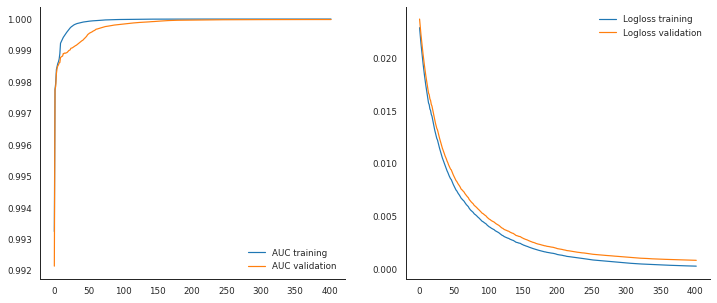

In [ ]:
# get evaluation results
evals_results_lgbm_hp_lr = clf_lgbm_hp_lr.evals_result_

# get loss and AUC by epoch
auc_train_lgbm_hp_lr, auc_val_lgbm_hp_lr, loss_train_lgbm_hp_lr, loss_val_lgbm_hp_lr, i_lgbm_hp_lr = get_lgbm_evals_results(evals_results_lgbm_hp_lr)

# plot loss and AUC
plot_model_performance(i_lgbm_hp_lr, auc_train_lgbm_hp_lr, auc_val_lgbm_hp_lr, loss_train_lgbm_hp_lr, loss_val_lgbm_hp_lr)

In [ ]:
# LGBMClassifier predictions
preds_lgbm_hp_lr = clf_lgbm_hp_lr.predict(X_test)
preds_lgbm_hp_lr_train = clf_lgbm_hp_lr.predict(X_train)
preds_lgbm_hp_lr_val = clf_lgbm_hp_lr.predict(X_val)

[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current v

In [ ]:
get_metrics(y_test, preds_lgbm_hp_lr)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  553481                  93
fraud (ground truth)                          43                2102

AUC on test set: 0.98989
FPR on test set: 0.0168
TPR on test set: 97.99534
FNR on test set: 2.00466
TNR on test set: 99.9832


In [ ]:
get_metrics(y_train, preds_lgbm_hp_lr_train, set_name="train")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  937580                  57
fraud (ground truth)                           0                5343

AUC on train set: 0.99997
FPR on train set: 0.00608
TPR on train set: 100.0
FNR on train set: 0.0
TNR on train set: 99.99392


In [ ]:
get_metrics(y_val, preds_lgbm_hp_lr_val, set_name="validation")

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  349012                  76
fraud (ground truth)                          22                2117

AUC on validation set: 0.99475
FPR on validation set: 0.02177
TPR on validation set: 98.97148
FNR on validation set: 1.02852
TNR on validation set: 99.97823


### Hyperparameter tuning conclusion

Through the different steps, I can see that adding L2 regularization helped to reduce the difference in AUC and logloss between training and validation sets, although negatively affecting FPR. However, tuning the learning offered a much better outcome.

In this case, AUC and TPR increase to very good levels, while FPR has a steep decrease compared to the previous step.

### Try different thresholds

As for XGBoost, all threshold offer a high AUC, although differences can be spotted for FPR and TPR using different thresholds.

Comparing to a default threshold of .50:

* Using a threshold of .70 reduces the TPR in .57%, while the FPR decreases in 35.71%

* With a threshold of .80 I will reduce the TPR in .80%, while decreasing the FPR in 55.35%

In light of these results, **I dicided to use a threshold of .80**. This threshold helps to significantly reduce the FPR without having a huge negative impact on the TPR.

In [ ]:
THRESHOLDS = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

In [ ]:
thresholds_results = get_scores_thresholds(y_test, X_test, clf_lgbm_hp_lr, THRESHOLDS)
display(thresholds_results)

Working on result for threshold: 0.9
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Working on result for threshold: 0.85
[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Working on 

TP     FP        TN    FN       TPR      FPR       TNR  \
Threshold                                                               
0.90       2072.0   22.0  553552.0  73.0  96.59674  0.00397  99.99603   
0.85       2076.0   32.0  553542.0  69.0  96.78322  0.00578  99.99422   
0.80       2085.0   42.0  553532.0  60.0  97.20280  0.00759  99.99241   
0.75       2087.0   50.0  553524.0  58.0  97.29604  0.00903  99.99097   
0.70       2090.0   60.0  553514.0  55.0  97.43590  0.01084  99.98916   
0.65       2094.0   63.0  553511.0  51.0  97.62238  0.01138  99.98862   
0.60       2096.0   68.0  553506.0  49.0  97.71562  0.01228  99.98772   
0.55       2099.0   82.0  553492.0  46.0  97.85548  0.01481  99.98519   
0.50       2102.0   93.0  553481.0  43.0  97.99534  0.01680  99.98320   
0.45       2102.0  103.0  553471.0  43.0  97.99534  0.01861  99.98139   
0.40       2104.0  117.0  553457.0  41.0  98.08858  0.02114  99.97886   
0.35       2104.0  133.0  553441.0  41.0  98.08858  0.02403  99.97597   
0.30       2104.0  154.0  553420.0  41.0  98.08858  0.02782  99.97218   
0.25       2107.0  175.0  553399.0  38.0  98.22844  0.03161  99.96839   
0.20       2110.0  213.0  553361.0  35.0  98.36830  0.03848  99.96152   
0.15       2110.0  259.0  553315.0  35.0  98.36830  0.04679  99.95321   
0.10       2111.0  336.0  553238.0  34.0  98.41492  0.06070  99.93930   

               FNR       BER    G-mean  F1_micro      AUC  
Threshold                                                  
0.90       3.40326  0.017036  9.828169   0.99983  0.98296  
0.85       3.21678  0.016113  9.837562   0.99982  0.98389  
0.80       2.79720  0.014024  9.858774   0.99982  0.98598  
0.75       2.70396  0.013565  9.863430   0.99981  0.98644  
0.70       2.56410  0.012875  9.870428   0.99979  0.98713  
0.65       2.37762  0.011945  9.879842   0.99979  0.98805  
0.60       2.28438  0.011483  9.884514   0.99979  0.98852  
0.55       2.14452  0.010797  9.891460   0.99977  0.98920  
0.50       2.00466  0.010107  9.898428   0.99976  0.98989  
0.45       2.00466  0.010116  9.898339   0.99974  0.98988  
0.40       1.91142  0.009663  9.902921   0.99972  0.99034  
0.35       1.91142  0.009677  9.902778   0.99969  0.99032  
0.30       1.91142  0.009696  9.902590   0.99965  0.99030  
0.25       1.77156  0.009016  9.909459   0.99962  0.99098  
0.20       1.63170  0.008351  9.916171   0.99955  0.99165  
0.15       1.63170  0.008392  9.915759   0.99947  0.99161  
0.10       1.58508  0.008229  9.917418   0.99933  0.99177

In [ ]:
# chosen threshold
THRESHOLD =.8

# predict probabilities and set the label based on the chosen threshold
preds_lgbm_lr_proba = np.ndarray.flatten((clf_lgbm_hp_lr.predict_proba(X_test)[:, 1] 
                                         > THRESHOLD)).astype("int32")

# print labels
display(preds_lgbm_lr_proba)

[LightGBM] [Warning] lambda_l2 is set=5.987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.987
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
# get metrics for the test set
get_metrics(y_test, preds_lgbm_lr_proba)

non-fraud (prediction)  fraud (prediction)
non-fraud (ground truth)                  553532                  42
fraud (ground truth)                          60                2085

AUC on test set: 0.98598
FPR on test set: 0.00759
TPR on test set: 97.2028
FNR on test set: 2.7972
TNR on test set: 99.99241


## Save model

In [ ]:
# save model in Colab
clf_lgbm_hp_lr.booster_.save_model(filename=os.path.join(model_path_gd, "LGBM_classifier"))

## Load model

In [ ]:
# load model in Colab
clf_lgbm = lightgbm.Booster(model_file=os.path.join(model_path_gd, "LGBM_classifier"))

In [ ]:
# compute auc score with loaded model
predictions_lgbm = clf_lgbm.predict(X_test)

# loaded models predicts probabilities instead of labels
predictions_lgbm = np.where(predictions_lgbm > 0.5, 1, 0)
print(roc_auc_score(y_test, predictions_lgbm))

0.9898926903668818


In [ ]:
# use TreeExplainer for tree-based models
explainer_lgbm = shap.TreeExplainer(clf_lgbm)

# get shap values
shap_values_lgbm = explainer_lgbm.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## Feature importances

Similarly to XGBoost, *amount of transactions each week by quarter (amt_week_quarter)* in the top of features importances, although *amount in transaction (amt_log)* has a higher contribution in LightGBM (1st position) than it does it XGBoost (5th position)

I also found *cumulative count of transactions per day (cumcount_trans_day)* to have a similar importance in both models, while *total seconds of the day (total_seconds_day9*, *hour of the day (hour)*, *distance between merchants (distance)* increased their contribution in LightGBM.

Interestingly, *cumulative sum of amount per day (cumsum_amt_day)* and *class of previous transaction (lag_fraud)* decrease their importance from XGBoost to LightGBM. This decrease is huge for *class of previous transaction (lag_fraud)*

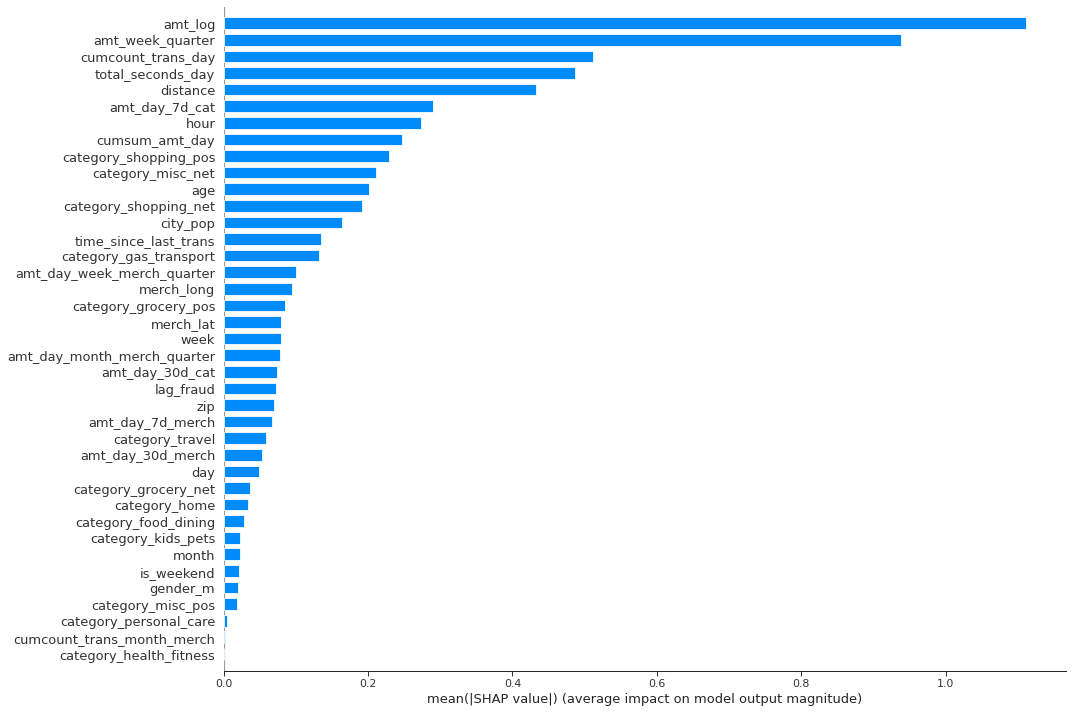

In [ ]:
shap.summary_plot(shap_values_lgbm[1], X_test_df, plot_type="bar", 
                  max_display=len(X_test_df.columns), plot_size=(15, 10))

The contribution of the features to model prediction is quite similar to XGBoost, however, some differences are noticeable.

* *shopping_net* contribution is inverted between XGBoost and LightGBM, and it also has a bigger contribution in the later model.

* For LightGBM, I see that higher values of *grocery_pos* contribute to either positive or negative predictions, while for XGBoost it only shows a positive association.

In [ ]:
shap.summary_plot(shap_values_lgbm[1], X_test_df, 
                  max_display=len(X_test_df.columns), plot_size=(15, 10))

In [ ]:
# shap.initjs()
# shap.force_plot(explainer_lgbm.expected_value[1], shap_values_lgbm[1][:1000,:], X_test_df.iloc[:1000,:])

# **Conclusion**

After tuning XGBoost LightGBM hyperparameters, I can conclude that both models perform similarly, although XGBoost gives us a better generalization to the test set in all of the indicators.

*Note. The following results are applying a threshold of .70 and .80 to XGBoost and LightGBM models, respectively.*

### **XGBoost vs. LightGBM performance**

* **XGB-AUC:* .986%** vs. LGBM-AUC: .985%

XGBoost performs outperforms than LightGBM in identifying fraud transactions: 

* **XGB-TPR: 97.389%** vs. LGBM-TPR: 97.202%

While LighGBM performs slighly better than XGBoost in classifying non-fraud transactions:

* **XGB-TNR: 99.995%** vs. LGBM-TNR: 99.992%

Concerning false positives, LightGBM also performes better than XGBoost:

* **XGB-FPR: .004%** vs. LGBM-FPR: .007%

While for false negatives, it is XGBoost the model that show a superior performance:

* **XGB-FNR: 2.610%** vs. LGBM-FNR: 2.797%

In conclusion, both models have a good generalization. In could be possible that there is a better way to do a good hyperparameter tuning, being more careful with the selection of the search ranges. This could be possible for professional with long experience working in binary classification, and more specifically in fraud detection.

One differences between XGBoost and LightGBM is the use of Early Stopping. LightGBM takes long to train, even using GPU, as it gives a lot of warnings in relation to no finding further splits with positive gain.

Also, there seems to be a bug in LightGBM when using GPU in some cases. When I tried to tune the learning rate using GPU, there was an error that is systematically found by different people when using GPU, but not when switching to CPU. This slows down the training process, especially for bigger datasets. In our case I do not have such a huge dataset and early stopping also helped to reduce training times when using CPU.